# Imports

In [1]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import wandb
from tqdm import tqdm

import wandb
wandb.login() 
os.environ["WANDB_DATA_DIR"] = "C:\\wandb_temp" 
print(f"DEBUG: WANDB_DATA_DIR ha sido forzada a: {os.environ['WANDB_DATA_DIR']}")

c:\Users\kidni\Desktop\u-net-segmentation\.venv\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
c:\Users\kidni\Desktop\u-net-segmentation\.venv\lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened

DEBUG: WANDB_DATA_DIR ha sido forzada a: C:\wandb_temp


# TL;DR

Se implementó una **U-Net** para segmentación de imágenes, optimizando su arquitectura y entrenamiento mediante técnicas modernas como **data augmentation**, **estratificación por tamaño de máscara**, y **barridos de hiperparámetros** con W&B. Se exploraron múltiples variantes arquitectónicas (padding=0 vs padding=1, UNetSE) y pérdidas combinadas (BCE + Dice). Finalmente, se seleccionó una **U-Net con padding=1**, reentrenada por más épocas, como el modelo más robusto. Aunque se alcanzó un **Dice Score de 0.9416 en validación**, el desempeño en Kaggle (0.895) reveló un *gap* de generalización. 

# 1. Data Loaders

In [2]:
TRAIN_IMAGES_DIR = 'train/images'
TRAIN_MASKS_DIR = 'train/masks'
BATCH_SIZE = 4

# Valores de Normalización Z-Score (Paso 2 del EDA)
MEAN = [0.515, 0.484, 0.460] 
STD = [0.314, 0.303, 0.303]

IMG_HEIGHT = 256
IMG_WIDTH = 256

all_files = os.listdir(TRAIN_IMAGES_DIR)
all_files = [f for f in all_files if f.endswith('.png') or f.endswith('.jpg')]


El *dataset* presenta imágenes homogéneas de **800×800 px**, sujetos **descentrados** y máscaras con **alta complejidad geométrica**, además de un marcado **desequilibrio de clases** (la clase positiva representa solo ~40%). A partir del EDA realizado, se definió un pipeline de *data augmentation* orientado a mejorar la capacidad de generalización del modelo. Se emplean transformaciones geométricas como *RandomResizedCrop*, *rotaciones suaves*, *shifts* y *ElasticTransform* para inducir **invariancia a posición, escala y deformaciones orgánicas**, fundamentales para capturar los contornos irregulares del sujeto. Asimismo, se incorporan transformaciones fotométricas como *ColorJitter*, *Gaussian Noise* y ajustes de contraste para compensar la **baja saturación** y la **ausencia de ruido** observada en las imágenes originales, evitando que la U-Net se sobreajuste a un dominio visual excesivamente “limpio”. Finalmente, se normalizan las imágenes con los valores de media y desviación estándar estimados en el dataset, siguiendo un esquema de **Z-Score** que estabiliza el entrenamiento. Este pipeline está directamente fundamentado en los hallazgos del EDA y orientado a maximizar el rendimiento del modelo según la métrica Dice.



In [3]:
def get_transforms(phase, mean, std):
    if phase == 'train':
        return A.Compose([
            A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),

            A.RandomResizedCrop(
                size=(IMG_HEIGHT, IMG_WIDTH),
                scale=(0.7, 1.0),
                ratio=(0.9, 1.1),
                p=0.35,
            ),

            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=15, p=0.4),

            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.05,
                rotate_limit=10,
                border_mode=cv2.BORDER_REFLECT_101,
                p=0.5
            ),

            A.ElasticTransform(alpha=1, sigma=40, alpha_affine=30, p=0.3),
            A.GridDistortion(num_steps=5, distort_limit=0.15, p=0.3),

            A.ColorJitter(
                brightness=0.3, contrast=0.3,
                saturation=0.4, hue=0.05,
                p=0.8
            ),

            A.OneOf([
                A.CLAHE(clip_limit=2.0),
                A.Equalize(),
            ], p=0.25),

            A.OneOf([
                A.MotionBlur(blur_limit=3),
                A.MedianBlur(blur_limit=3),
                A.Sharpen(alpha=(0.2, 0.5), lightness=(0.7, 1.0)),
            ], p=0.4),

            A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),

            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])
    
    else:
        return A.Compose([
            A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ])


In [4]:
class HumanSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = os.listdir(image_dir)
        self.image_files = [f for f in self.image_files if f.endswith(('.png', '.jpg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        img_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # RGB (H, W, 3)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (H, W)
        mask = (mask > 0).astype(np.float32) # Binarizar 0/1 (float32)

        return image, mask


class SubsetWrapper(Dataset): 
    """Aplica el transform específico (train o val) al Subset."""
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image_np, mask_np = self.subset[idx]
        
        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image_tensor = augmented['image'] # (3, H, W)
            mask_tensor = augmented['mask']   # (H, W)
            
            if mask_tensor.ndim == 2:
                mask_tensor = mask_tensor.unsqueeze(0) 
            
            return image_tensor, mask_tensor
        

        return image_np, mask_np

## Justificación del binning y de la estratificación por tamaño de máscara

El *dataset* presenta una alta variabilidad en la proporción de píxeles pertenecientes a la clase positiva, tal como se observó en el EDA (la clase “Persona” ocupa en promedio ~40%, pero con una dispersión significativa entre imágenes). Esta variabilidad afecta directamente la dificultad de cada muestra: imágenes con máscaras muy pequeñas son más desafiantes que aquellas donde el sujeto ocupa gran parte del frame.

Para evitar que la validación quede sesgada hacia imágenes “fáciles” o “difíciles”, se utiliza una división estratificada basada en el **tamaño relativo de la máscara**. Como esta proporción es un valor continuo, se discretiza mediante *binning* en 10 categorías, permitiendo aplicar `stratify=` en `train_test_split`. De este modo, tanto el conjunto de entrenamiento como el de validación mantienen distribuciones similares de tamaños de máscara, lo que genera métricas más estables, comparables y representativas.

La medida utilizada (`mask.mean()` o equivalentemente `mask.sum()/(H·W)`) cuantifica la fracción de píxeles positivos de cada máscara, actuando como un proxy adecuado para balancear la complejidad relativa de las imágenes.


In [5]:
from sklearn.model_selection import train_test_split


def get_dataloaders(train_ratio=0.8, batch_size=BATCH_SIZE, num_workers=0):
    
    full_dataset = HumanSegmentationDataset(
        image_dir=TRAIN_IMAGES_DIR, 
        mask_dir=TRAIN_MASKS_DIR
    )

    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    mask_areas = []
    for fname in full_dataset.image_files:
        mask_path = os.path.join(TRAIN_MASKS_DIR, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_areas.append(mask.mean())  

    # Agrupamos las áreas en 10 "bins" de igual tamaño
    bins = np.linspace(0, 255, 10)
    mask_area_bins = np.digitize(mask_areas, bins)

    train_files, val_files = train_test_split(
        full_dataset.image_files,
        test_size=0.2,
        random_state=42,
        stratify=mask_area_bins
    )

    train_subset = [ (cv2.cvtColor(cv2.imread(os.path.join(TRAIN_IMAGES_DIR, f)), cv2.COLOR_BGR2RGB),
                  (cv2.imread(os.path.join(TRAIN_MASKS_DIR, f), cv2.IMREAD_GRAYSCALE) > 0).astype(np.float32))
                 for f in train_files]

    val_subset = [ (cv2.cvtColor(cv2.imread(os.path.join(TRAIN_IMAGES_DIR, f)), cv2.COLOR_BGR2RGB),
                  (cv2.imread(os.path.join(TRAIN_MASKS_DIR, f), cv2.IMREAD_GRAYSCALE) > 0).astype(np.float32))
                 for f in val_files]

    train_transforms = get_transforms('train', MEAN, STD)
    val_transforms = get_transforms('val', MEAN, STD)

    train_dataset_final = SubsetWrapper(train_subset, train_transforms)
    val_dataset_final = SubsetWrapper(val_subset, val_transforms)

    train_loader = DataLoader(
        train_dataset_final, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset_final, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=True
    )
    
    print(f"✅ DataLoaders listos. Train: {len(train_dataset_final)} | Val: {len(val_dataset_final)}")
    return train_loader, val_loader

In [ ]:
def visualize_batch(data_loader, title="Batch de Imágenes", num_samples=4, mean=MEAN, std=STD, figsize=(6, 3)):
    """Extrae un batch y visualiza las imágenes y sus máscaras."""
    
    images, masks = next(iter(data_loader))
    
    fig_width, fig_height_base = figsize
    fig, axes = plt.subplots(num_samples, 2, figsize=(fig_width, fig_height_base * num_samples))
    fig.suptitle(title, fontsize=12)

    for i in range(min(num_samples, len(images))):
        img_tensor = images[i].cpu()
        mask_tensor = masks[i].cpu().squeeze(0) 


        for t, m, s in zip(img_tensor, mean, std):
            t.mul_(s).add_(m)
        
        # PyTorch es C, H, W. Matplotlib espera H, W, C.
        img_np = img_tensor.permute(1, 2, 0).numpy()
        mask_np = mask_tensor.numpy()
        
        axes[i, 0].imshow(img_np.clip(0, 1)) 
        axes[i, 0].set_title(f"Muestra {i}: Imagen", fontsize=9)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_np, cmap='gray') # Usar escala de grises para la máscara binaria
        axes[i, 1].set_title(f"Muestra {i}: Máscara", fontsize=9)
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
train_loader, val_loader = get_dataloaders()

✅ DataLoaders listos. Train: 1706 | Val: 427


c:\Users\kidni\Desktop\u-net-segmentation\.venv\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\kidni\AppData\Local\Temp\ipykernel_22552\1323355973.py:25: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=40, alpha_affine=30, p=0.3),
C:\Users\kidni\AppData\Local\Temp\ipykernel_22552\1323355973.py:45: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),


In [ ]:
images, masks = next(iter(val_loader))

print("Shape del batch de imágenes:", images.shape)
print("Shape del batch de máscaras:", masks.shape)


Shape del batch de imágenes: torch.Size([4, 3, 256, 256])
Shape del batch de máscaras: torch.Size([4, 1, 256, 256])


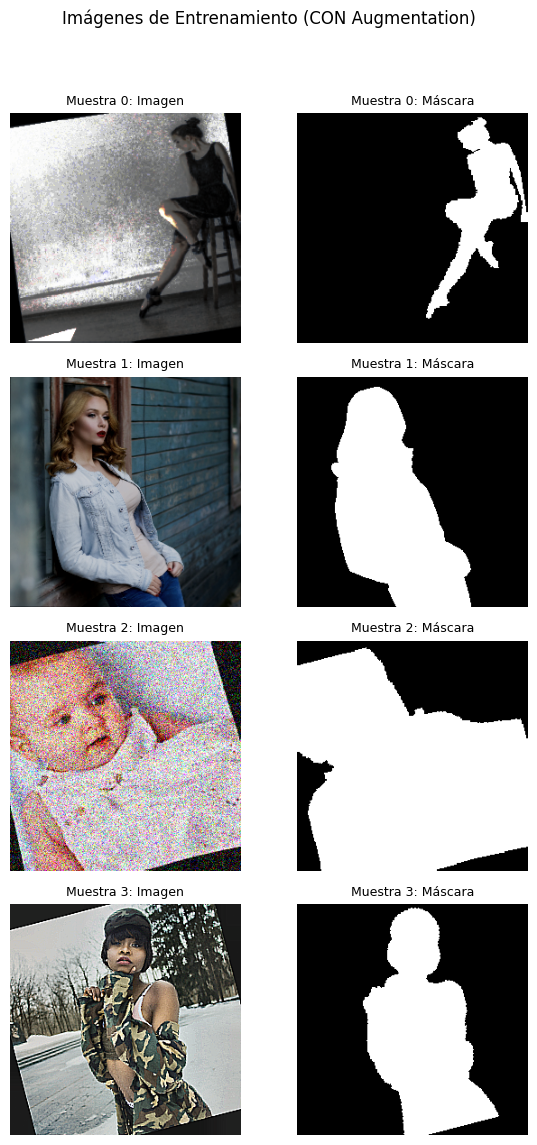

In [ ]:
visualize_batch(train_loader, "Imágenes de Entrenamiento (CON Augmentation)", num_samples=4)

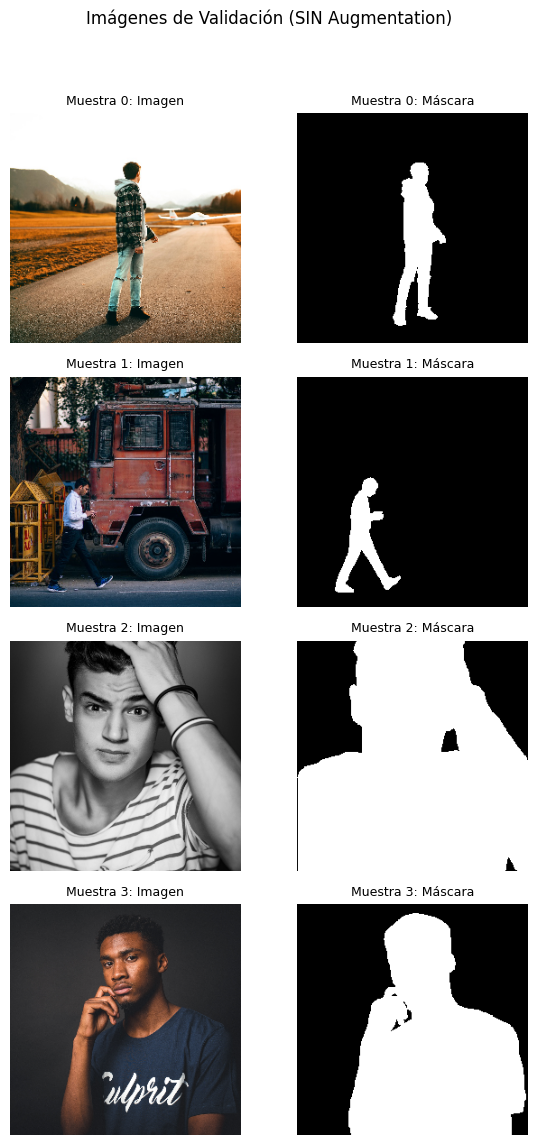

In [ ]:
visualize_batch(val_loader, "Imágenes de Validación (SIN Augmentation)", num_samples=4)

# 2. U-Net Implementada

La arquitectura utilizada es una **U-Net completamente parametrizable**, diseñada para reproducir fielmente el modelo del paper original o una versión moderna con mejoras opcionales. Esta flexibilidad permite realizar experimentos controlados sobre el impacto de la normalización, activación, padding y regularización en el desempeño final según los hallazgos del EDA.

## Parámetros Principales del Modelo

| Parámetro | Módulo | Explicación |
|----------|--------|-------------|
| **`activation`** | `DoubleConv` | Permite elegir entre **ReLU**, **LeakyReLU** o **ELU**, controlando la dinámica del gradiente. Activaciones suavizadas (e.g., ELU) pueden ayudar en regiones de bordes complejos, tal como se observó en el EDA. |
| **`use_batchnorm`** | `DoubleConv` | Activa la **Normalización por Lotes**, reduciendo la covariate shift y estabilizando el entrenamiento, especialmente útil cuando se aplica un *augmentation* fuerte. |
| **`padding`** | `DoubleConv`, `Up` | Con `padding=0` se reproduce el comportamiento del *paper original*, donde la rama de *skip connection* debe recortarse para concatenar. Con `padding=1` se obtiene una **conv tipo “same”**, útil para simplificar entrenamiento y mantener dimensiones constantes. |
| **`dropout`** | `DoubleConv` | Añade **Dropout 2D** luego de las convoluciones para combatir el *overfitting*. Este valor puede relacionarse con la complejidad del dataset y el tamaño de la máscara analizado en el EDA. |
| **`depth` / `initial_filters`** | `UNet` | Controlan la capacidad expresiva del modelo: profundidad del encoder–decoder y número de canales iniciales. Con `depth=4` y `initial_filters=64` se replica exactamente la U-Net del paper (64→128→256→512→1024). |
| **`final_activation`** | `UNet` | Aplica **Sigmoid** (segmentación binaria) o **Softmax** (multiclase). Para este proyecto, Sigmoid es el ajuste natural. |
| **`init_weights`** | Función Auxiliar | Permite seleccionar el método de inicialización (**Kaiming**, **Xavier**, **Normal**) para asegurar una convergencia estable, especialmente importante con activaciones distintas de ReLU. |

### Nota sobre las Skip Connections
Las *skip connections* se implementan exactamente como en la U-Net original, concatenando mapas de características del encoder con los del decoder. Esto es crucial para preservar **detalles espaciales finos**, coherente con lo observado en el EDA (máscaras con bordes complejos, compacidad alta y contornos irregulares).
Las convoluciones de transposición (`ConvTranspose2d`) permiten un **upsampling aprendido**, más expresivo que interpolación bilineal, lo cual mejora la calidad de los bordes segmentados.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Callable, Optional

def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU(inplace=True)
    if name == "leaky":
        return nn.LeakyReLU(0.1, inplace=True)
    if name == "elu":
        return nn.ELU(inplace=True)
    raise ValueError(f"Unknown activation '{name}'")

class DoubleConv(nn.Module):
    """
    (Conv -> (BatchNorm) -> Activation) * 2
    padding can be 0 (paper) or 1 (same conv)
    """
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        activation: str = "relu",
        use_batchnorm: bool = False,
        padding: int = 0,
        dropout: float = 0.0
    ):
        super().__init__()
        act = get_activation(activation)
        layers = []
        # first conv
        layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=padding))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_ch))
        layers.append(act)
        # second conv
        layers.append(nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=padding))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_ch))
        layers.append(act)
        if dropout and dropout > 0.0:
            layers.append(nn.Dropout2d(dropout))
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)



class Down(nn.Module):
    """
    MaxPool2d(2) followed by DoubleConv
    """
    def __init__(self, in_ch, out_ch, **double_conv_kwargs):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch, **double_conv_kwargs)

    def forward(self, x):
        x = self.pool(x)
        return self.conv(x)


class Up(nn.Module):
    """
    Up-conv (ConvTranspose2d) then concat with skip connection and DoubleConv.
    If padding=0 (paper style), we crop x2 to x1 size before concat.
    """
    def __init__(self, in_ch, out_ch, padding: int = 0, **double_conv_kwargs):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch, padding=padding, **double_conv_kwargs)
        self.padding = padding

    def forward(self, x1, x2):
        # x1: decoder input (to be upsampled)
        # x2: encoder skip connection
        x1 = self.up(x1)
        if self.padding == 0:
            # crop x2 to x1 size (como el paepr)
            diffY = x2.size(2) - x1.size(2)
            diffX = x2.size(3) - x1.size(3)
            # ensure diffs are non-negative
            if diffY < 0 or diffX < 0:
                raise RuntimeError("x1 larger than x2 when trying to crop; check input sizes or padding.")
            x2 = x2[:, :, diffY // 2 : x2.size(2) - (diffY - diffY // 2),
                        diffX // 2 : x2.size(3) - (diffX - diffX // 2)]
        else:
 
            if x2.size(2) != x1.size(2) or x2.size(3) != x1.size(3):
                diffY = x2.size(2) - x1.size(2)
                diffX = x2.size(3) - x1.size(3)
                x2 = x2[:, :, diffY // 2 : x2.size(2) - (diffY - diffY // 2),
                            diffX // 2 : x2.size(3) - (diffX - diffX // 2)]

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        initial_filters: int = 64,
        depth: int = 4,                    # number of down steps (paper usa 4)
        activation: str = "relu",
        use_batchnorm: bool = False,
        padding: int = 0,                  # 0 -> original paper behavior; 
        dropout: float = 0.0,              # dropout applied in DoubleConv after second conv if >0
        final_activation: Optional[str] = None  # "sigmoid" / "softmax" / None
    ):
        """
        depth=4 means channels: 64,128,256,512,1024 (paper)
        """
        super().__init__()
        assert depth >= 1, "depth must be >= 1"
        f = initial_filters
        self.padding = padding
        self.final_activation = final_activation

        # contracting path
        self.inc = DoubleConv(n_channels, f, activation=activation, use_batchnorm=use_batchnorm, padding=padding, dropout=dropout)
        self.downs = nn.ModuleList()
        chs = [f * (2 ** i) for i in range(depth + 1)]  # length depth+1, last is bottleneck channels
        for i in range(depth):
            self.downs.append(Down(chs[i], chs[i+1], activation=activation, use_batchnorm=use_batchnorm, padding=padding, dropout=dropout))

        # expanding path: ups (depth of them)
        self.ups = nn.ModuleList()
        for i in range(depth, 0, -1):
            # in_ch for Up is chs[i] (current top) and we want out_ch=chs[i-1]
            self.ups.append(Up(chs[i], chs[i-1], padding=padding, activation=activation, use_batchnorm=use_batchnorm, dropout=dropout))

        # final 1x1 conv
        self.outc = OutConv(chs[0], n_classes)

    def forward(self, x):
        # contracting path
        x_enc = []
        x1 = self.inc(x)
        x_enc.append(x1)
        xi = x1
        for d in self.downs:
            xi = d(xi)
            x_enc.append(xi)

        # At this point x_enc[-1] is the bottleneck output
        # start decoding: iterate ups and corresponding encoder features reversed (exclude last: it's the same)
        x = x_enc[-1]
        # iterate over ups and skip features (skip features are x_enc[-2], x_enc[-3], ...)
        for i, up in enumerate(self.ups):
            # skip feature is from x_enc[-2 - i]
            skip = x_enc[-2 - i]
            x = up(x, skip)

        logits = self.outc(x)
        if self.final_activation is not None:
            if self.final_activation.lower() == "sigmoid":
                logits = torch.sigmoid(logits)
            elif self.final_activation.lower() == "softmax":
                # softmax across channel dimension
                logits = torch.softmax(logits, dim=1)
            else:
                raise ValueError("Unknown final_activation: use 'sigmoid' or 'softmax' or None")
        return logits

def init_weights(model: nn.Module, mode: str = "kaiming"):
    """
    mode: 'kaiming' (He), 'xavier' (Glorot), 'normal'
    Applies init to Conv2d and Linear (BatchNorm biases are zeroed).
    """
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            if mode == "kaiming":
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif mode == "xavier":
                nn.init.xavier_normal_(m.weight)
            elif mode == "normal":
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
            else:
                raise ValueError("init mode must be 'kaiming', 'xavier' or 'normal'")
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            if mode == "kaiming":
                nn.init.kaiming_normal_(m.weight)
            elif mode == "xavier":
                nn.init.xavier_normal_(m.weight)
            else:
                nn.init.normal_(m.weight, 0, 0.01)
            if m.bias is not None:
                nn.init.zeros_(m.bias)


# 3. Pérdida y Métrica

In [7]:
# Recortar centro de la máscara para que coincida con output
# Mantenemos tu función original de recorte
def crop_to_match(output, target):
    """Realiza el recorte central si las dimensiones no coinciden."""
    _, _, h_out, w_out = output.shape
    _, _, h_tgt, w_tgt = target.shape
    
    if h_out == h_tgt and w_out == w_tgt:
        return target # No hay recorte necesario (caso padding=1)
        
    # Si son diferentes (caso padding=0), aplicamos el recorte
    delta_h = (h_tgt - h_out) // 2
    delta_w = (w_tgt - w_out) // 2
    
    # Verificación de sanity (el target debe ser más grande)
    if delta_h < 0 or delta_w < 0:
         # por seguridad viste
         return target 

    return target[:, :, delta_h:delta_h + h_out, delta_w:delta_w + w_out]


Dado que el dataset presenta un **desequilibrio fuerte entre fondo y objeto** (confirmado en el EDA, donde la clase positiva ocupa solo ~40%), se utiliza una pérdida compuesta que combina:

1. **BCEWithLogitsLoss**  
2. **Dice Loss**

Estas dos componentes son complementarias y resuelven problemas distintos:

### BCE (Binary Cross Entropy con logits)
- Entrega **gradientes estables**, incluso cuando las predicciones iniciales están lejos del objetivo.  
- Ayuda a clasificar correctamente la gran cantidad de píxeles de fondo.  
- Es ideal para la etapa temprana del entrenamiento, donde el modelo aún no segmenta nada.

### Dice Loss
- Mide la **superposición directa** entre la máscara predicha y la máscara real.  
- Es **invariante al número total de píxeles** y por lo tanto es robusta al desequilibrio.  
- Obliga al modelo a refinar los **bordes** y la **forma completa** del objeto, algo crítico para este dataset (bordes complejos, máscaras irregulares y con "agujeros", como se observó en el EDA).  
- Además, coincide con la **métrica principal de evaluación (Dice Coefficient)** utilizada por la competencia de Kaggle.

### Por qué combinarlas
El BCE entrena la clasificación pixel a pixel con estabilidad, mientras que el Dice Loss optimiza la forma global de la segmentación.  
La combinación aprovecha lo mejor de ambos mundos:

- **BCE** → estabiliza el entrenamiento  
- **Dice** → mejora la calidad final de la máscara  

El parámetro `dice_weight` permite ajustar su proporción.  




In [8]:
class DiceLossComponent(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLossComponent, self).__init__()
        self.smooth = smooth

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        #nputs ya son probabilidades (0-1) y targets ya están recortados
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (inputs * targets).sum()
        dice_coefficient = (2. * intersection + self.smooth) / (
            inputs.sum() + targets.sum() + self.smooth
        )
        return 1. - dice_coefficient


class CombinedLoss(nn.Module):
    def __init__(self, dice_weight: float = 0.5):
        super().__init__()
        self.dice_component = DiceLossComponent(smooth=1e-6)
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='mean') 
        
        self.dice_weight = dice_weight
        self.bce_weight = 1.0 - dice_weight


    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Funciona para padding=0 y padding=1.
        targets será recortado por crop_to_match si es necesario (padding=0).
        """

        targets_consistent = crop_to_match(inputs, targets)

        bce = self.bce_loss(inputs, targets_consistent) 
        
        probs = torch.sigmoid(inputs)
        dice = self.dice_component(probs, targets_consistent)
        
        combined_loss = (self.bce_weight * bce) + (self.dice_weight * dice)
        
        return combined_loss



def dice_coefficient_adjustable(pred_logits, targets, threshold: float = 0.5, smooth=1e-6):
    """
    Calcula el Dice Coefficient de forma agnostica al padding.
    """
    probs = torch.sigmoid(pred_logits)
    
    preds = (probs > threshold).float() 
    

    targets_consistent = crop_to_match(preds, targets) 

    preds = preds.reshape(-1)
    targets_consistent = targets_consistent.reshape(-1)

    intersection = (preds * targets_consistent).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets_consistent.sum() + smooth)
    return dice

# 4. Funciones Generales

In [9]:
def train_fn(model, data_loader, optimizer, criterion, device, epoch, wandb = True):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    
    # Usamos enumerate para obtener el índice del lote (step)
    for batch_idx, (images, masks) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images) 

        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        dice_score = dice_coefficient_adjustable(outputs, masks, threshold=0.5)
        running_loss += loss.item() * images.size(0)
        running_dice += dice_score.item() * images.size(0)

        
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_dice = running_dice / len(data_loader.dataset)

    if wandb:
        wandb.log({
            "train/loss": epoch_loss,
            "train/dice": epoch_dice,
            "epoch": epoch
        })
    
    return epoch_loss, epoch_dice

@torch.no_grad()
def validate_fn(model, data_loader, criterion, device, epoch, wandb = True):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    
    for images, masks in tqdm(data_loader, desc=f"Validation Epoch {epoch}"):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)

        
        loss = criterion(outputs, masks)
        dice_score = dice_coefficient_adjustable(outputs, masks, threshold=0.5)

        running_loss += loss.item() * images.size(0)
        running_dice += dice_score.item() * images.size(0)
        
    # Cálculo de métricas promedio por época
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_dice = running_dice / len(data_loader.dataset)
    
    if wandb:

        wandb.log({
            "validation/loss": epoch_loss,
            "validation/dice": epoch_dice,
            "epoch": epoch
        })
    
    return epoch_loss, epoch_dice

Se utiliza un ciclo clásico de entrenamiento/validación con Early Stopping basado en la pérdida de validación. En cada época se registran las métricas de entrenamiento y validación (Loss y Dice), y se guarda automáticamente el mejor modelo obtenido.


In [10]:
import torch
import torch.nn as nn
import os
import copy 
def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    config: dict,  # Configuración pasada por wandb.config
    device: torch.device,
    patience: int = 5,
):
    """
    Orquesta el ciclo de entrenamiento, llama a train_fn y validate_fn,
    e implementa Early Stopping.
    """
    

    criterion = CombinedLoss(dice_weight=0.5).to(device)

    if config.optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    elif config.optimizer == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9)
    else:
        raise ValueError(f"Optimizer {config.optimizer} not supported.")

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    
    print(f"Starting training for {config.epochs} epochs with patience={patience}...")

    for epoch in range(config.epochs):
        # train_fn ya hace logging de train/loss y train/dice
        train_loss, train_dice = train_fn(model, train_loader, optimizer, criterion, device, epoch)

        # validate_fn ya hace logging de validation/loss y validation/dice
        val_loss, val_dice = validate_fn(model, val_loader, criterion, device, epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            
            # Guardar una copia profunda del estado del mejor modelo
            best_model_state = copy.deepcopy(model.state_dict())
            
            wandb.run.summary["best_val_loss"] = best_val_loss
            wandb.run.summary["best_val_dice"] = val_dice 
            
        else:
            epochs_no_improve += 1
            print(f"Validation loss did not improve. Count: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print(f"Early Stopping triggered at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
            break

        print(f"\nÉpoca {epoch}/{config.epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print("Training finished.")
    return model, {"best_val_loss": best_val_loss, "best_val_dice": val_dice}

Luego, tenemos esta función que sube como artifact el mejor modelo entrenado a W&B para su posterior evaluación y análisis.

In [11]:
import wandb
import json
import re
import os


def upload_best_model_from_sweep(
    sweep_id: str,
    model_name: str,
    project: str = "imagenette",
    models_dir: str = "models",
    add_tag: str | None = "best_model",
):
    """
    Busca la mejor run (mínimo val_loss) en un sweep de W&B y sube su modelo como artifact.
    Usa la misma lógica probada que extrajo correctamente los val_loss.

    Args:
        sweep_id (str): ID del sweep (por ejemplo 'abcd1234').
        model_name (str): Nombre lógico del modelo (por ejemplo 'lenet' o 'tinycnn').
        project (str): Nombre del proyecto de W&B (por defecto 'imagenette').
        models_dir (str): Carpeta local donde están los archivos .pth.
        add_tag (str | None): Tag opcional a agregar al artifact.
    """

    api = wandb.Api()
    sweep = api.sweep(f"{project}/{sweep_id}")

    # --- FUNCIÓN ORIGINAL PARA EXTRAER val_loss ---
    def get_val_loss(run):
        """
        Extrae val_loss de una run W&B de forma robusta.
        Siempre devuelve un float (inf si no se encuentra).
        """
        try:
            # 1) intento directo desde summary
            try:
                if hasattr(run, "summary") and getattr(run.summary, "get", None):
                    v = run.summary.get("validation/dice")
                    if v is not None:
                        return float(v)
            except Exception:
                pass

            # 2) fallback a _json_dict (puede ser dict o str multiline)
            summary = getattr(run.summary, "_json_dict", None)
            if isinstance(summary, dict):
                v = summary.get("validation/dice")
                if v is not None:
                    return float(v)
            elif isinstance(summary, str):
                lines = [l.strip() for l in summary.splitlines() if l.strip()]
                for line in reversed(lines):
                    try:
                        obj = json.loads(line)
                        if "validation/dice" in obj:
                            return float(obj["validation/dice"])
                    except Exception:
                        m = re.search(r'"validation/dice"\s*:\s*([0-9.+-eE]+)', line)
                        if m:
                            return float(m.group(1))
                # última oportunidad: buscar en todo el string
                m = re.search(r'"validation/dice"\s*:\s*([0-9.+-eE]+)', summary)
                if m:
                    return float(m.group(1))

        except Exception:
            pass

        # Si todo falla, devolver inf (float) en lugar de None
        return float("inf")

    # --- ELEGIR MEJOR RUN ---
    losses = []
    for run in sweep.runs:
        try:
            l = get_val_loss(run)
        except Exception:
            l = float("inf")
        losses.append((l, run))
        print(f"• {run.name} ({run.id}) → validation/dice = {l if l != float('inf') else 'None'}")

    # Elegir la mejor run (la que tenga MAYOR validation/dice)
    best_loss, best_run = max(losses, key=lambda x: x[0])
    if best_loss == float("inf"):
        print(f"⚠️ No se pudo extraer validation/dice de ninguna run del sweep {sweep_id}.")
        return

    print(f"\n🏆 Mejor run encontrada:")
    print(f"   • Run: {best_run.name} ({best_run.id})")
    print(f"   • validation/dice = {best_loss:.4f}")
    print(f"   • Sweep ID: {sweep_id}")

    # --- BUSCAR ARCHIVO DEL MODELO ---
    best_model_path = os.path.join(models_dir, f"sweep_run_{best_run.id}.pth")
    if not os.path.exists(best_model_path):
        print(f"❌ No se encontró el archivo del modelo en {best_model_path}")
        return

    # --- SUBIR ARTIFACT ---
    run_upload = wandb.init(
        project=project,
        name=f"upload_best_{model_name}_{sweep_id}",
        reinit=True,
        tags=["artifact_upload", add_tag] if add_tag else ["artifact_upload"]
    )

    artifact_name = f"{model_name}_best_model_{sweep_id}"
    artifact = wandb.Artifact(
        name=artifact_name,
        type="model",
        description=f"Mejor modelo ({model_name}) del sweep {sweep_id} (run {best_run.id})",
        metadata={
            "sweep_id": sweep_id,
            "run_id": best_run.id,
            "val_loss": best_loss,
        }
    )

    artifact.add_file(best_model_path)
    wandb.log_artifact(artifact)
    wandb.finish()

    print(f"\n✅ Artifact '{artifact_name}' subido correctamente a W&B.")


# 5. Ver Predicciones

## Justificación del pipeline de inferencia y visualización

Para la etapa de inferencia se mantiene un pipeline consistente con el entrenamiento, aplicando únicamente las transformaciones estrictamente necesarias: **redimensionado y normalización**. La función `predict_and_upsample` permite generar predicciones precisas en imágenes de cualquier tamaño, procesándolas a **256×256** (dimensión esperada por la U-Net) y luego reescalando la máscara resultante al tamaño original mediante **interpolación bilineal**, asegurando compatibilidad con las imágenes completas del conjunto de evaluación. El umbral fijo (`threshold=0.5`) estabiliza la binarización de la salida sigmoid. Finalmente, la función `visualize_multiple_comparisons` integra en un mismo panel la imagen original, la máscara real y la predicción sobrepuesta, permitiendo realizar una evaluación cualitativa de los resultados, identificar errores estructurales y validar visualmente la coherencia del modelo más allá de las métricas numéricas.



In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt

IMG_HEIGHT = 256
IMG_WIDTH = 256
MEAN = [0.515, 0.484, 0.460]
STD = [0.314, 0.303, 0.303]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = "unet_best_checkpoint.pth.tar"
INFERENCE_THRESHOLD = 0.5


def get_test_transforms(mean, std):
    """Transformaciones necesarias para la inferencia (Redimensionar y Normalizar)."""
    return A.Compose([
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),
        A.Normalize(mean=mean, std=std, max_pixel_value=255.0),
        ToTensorV2(),
    ])


def predict_and_upsample(model, image_np, original_shape, device):
    """
    Predice una máscara binaria a partir de una imagen RGB.
    - Redimensiona la imagen a 256x256
    - Predice con el modelo
    - Escala la máscara resultante al tamaño original (ej: 800x800)
    """
    model.eval()

    test_transforms = get_test_transforms(MEAN, STD)
    transformed = test_transforms(image=image_np)
    image_tensor = transformed['image'].unsqueeze(0).to(device) 

    with torch.no_grad():
        output_logits = model(image_tensor)  # (1, 1, H_out, W_out)

        probs = torch.sigmoid(output_logits)

        H_orig, W_orig = original_shape[:2]
        upsampled = F.interpolate(
            probs,
            size=(H_orig, W_orig),
            mode='bilinear',
            align_corners=False
        )

        final_mask = (upsampled.squeeze().cpu().numpy() > INFERENCE_THRESHOLD).astype(np.uint8)

    return final_mask


def load_best_model(path, model, device):
    """
    Carga un modelo U-Net desde un checkpoint (.pth o .pth.tar).
    Si el archivo contiene 'state_dict' y 'best_dice', los usa.
    Si solo contiene los pesos, también los carga correctamente.
    """
    print(f"🧩 Cargando checkpoint desde {path}...")
    checkpoint = torch.load(path, map_location=device)

    if isinstance(checkpoint, dict) and "state_dict" in checkpoint:
        model.load_state_dict(checkpoint["state_dict"])
        best_dice = checkpoint.get("best_dice", None)
        if best_dice is not None:
            print(f"✅ Modelo cargado. Mejor Dice Score de validación: {best_dice:.4f}")
        else:
            print("✅ Modelo cargado (sin métrica almacenada).")
    else:
        # Caso: archivo .pth que contiene directamente los pesos
        model.load_state_dict(checkpoint)
        print("✅ Modelo cargado desde archivo de pesos plano (.pth).")

    model.to(device)
    model.eval()
    return model


In [13]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math 

def visualize_multiple_comparisons(model, data_list, device):
    """
    Visualiza comparaciones de segmentación (Original, GT, Predicción) para 
    múltiples ejemplos, sin calcular ni mostrar el Dice Score.

    Args:
        model (torch.nn.Module): Modelo de segmentación entrenado.
        data_list (list): Lista de tuplas [(image_path, mask_path), ...].
        device (torch.device): Dispositivo (CPU o CUDA).
    """
    
    N_COLUMNS = 3
    N_ROWS = len(data_list)
    
    fig, axes = plt.subplots(N_ROWS, N_COLUMNS, figsize=(15, 4 * N_ROWS))
    
    if N_ROWS == 1:
        axes = np.expand_dims(axes, axis=0)

    plt.suptitle(f'Visualización de Segmentación para {N_ROWS} Ejemplos', fontsize=18, y=1.02)
    
    col_titles = ['Imagen Original', 'Máscara Ground Truth', 'Predicción Overlay']
    
    for i, (image_path, mask_path) in enumerate(data_list):
        
        original_img_np = np.array(Image.open(image_path).convert("RGB"))
        ground_truth_mask_np = np.array(Image.open(mask_path).convert("L")) / 255
        original_shape = original_img_np.shape[:2]


        final_mask_800x800 = predict_and_upsample(model, original_img_np, original_shape, device)
        
        overlay_img = original_img_np.copy()
        purple_color = (200, 50, 200) 
        mask_pixels = final_mask_800x800 == 1
        overlay_img[mask_pixels] = (
            overlay_img[mask_pixels] * 0.5 + np.array(purple_color) * 0.5
        ).astype(np.uint8)

        
        # Imagen Original
        axes[i, 0].imshow(original_img_np)
        if i == 0: axes[i, 0].set_title(col_titles[0])
        
        # Máscara Ground Truth
        axes[i, 1].imshow(ground_truth_mask_np, cmap='gray')
        if i == 0: axes[i, 1].set_title(col_titles[1])
        
        # Predicción Overlay
        axes[i, 2].imshow(overlay_img)
        if i == 0: axes[i, 2].set_title(col_titles[2])
        
        for col in range(N_COLUMNS):
            axes[i, col].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# 6. Predecir en Test

In [14]:
def rle_encode(img):
    """
    Convierte una máscara binaria (1s y 0s) en una cadena de Run-Length Encoding.
    img: numpy array de 1s y 0s, 1 - objeto, 0 - fondo
    Returns: cadena de RLE
    """
    pixels = img.T.flatten() 
    
    pixels = np.concatenate([[0], pixels, [0]])
    
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [15]:
import pandas as pd
def generate_submission(model, test_dir, device):
    
    # Lista para almacenar los resultados (ImageId, EncodedPixels)
    results = []
    
    # Obtener la lista de nombres de archivo (asumiendo formato .png)
    image_files = sorted([f for f in os.listdir(test_dir) if f.endswith('.png')])
    
    print(f"Iniciando predicción para {len(image_files)} imágenes de prueba...")

    for i, filename in enumerate(image_files):
        
        # 1. Cargar Imagen Original
        filepath = os.path.join(test_dir, filename)
        original_img_np = np.array(Image.open(filepath).convert("RGB"))
        original_shape = original_img_np.shape[:2] # (Alto, Ancho)
        
        # 2. Predecir y Re-escalar a 800x800
        # **Usamos la función que integra Resize(256) -> UNet -> Upsample(800)**
        final_mask_800x800 = predict_and_upsample(model, original_img_np, original_shape, device)
        
        # 3. Codificar RLE
        rle_encoded = rle_encode(final_mask_800x800)
        
        # 4. Guardar Resultado
        results.append({'id': filename, 'encoded_pixels': rle_encoded})
        
        # Progreso
        if (i + 1) % 50 == 0:
            print(f"Predicciones procesadas: {i + 1}/{len(image_files)}")

    # 5. Crear DataFrame de Envío
    submission_df = pd.DataFrame(results)
    return submission_df



# 7. U-Net Paper

In [33]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_paper = UNet(n_channels=3, n_classes=1, initial_filters=64, depth=4,
             activation="relu", use_batchnorm=False, padding=0, dropout=0.0,
             final_activation=None).to(DEVICE)

#no usamos ninguna activacion al final porque diceloss ya aplica sigmoid internamente
init_weights(model_paper, mode="normal")  # paper no especifica init, normal es seguro

In [28]:
#codigo para comprobar la cantidad de capas conv2d y convtranspose2d y ver si es igual al paper

## At the nal layer a 1x1 convolution is used to map each 64
## component feature vector to the desired number of classes. In total the network
## has 23 convolutional layers.
def count_convs(m):
    conv2d = []
    convtrans = []
    for name, module in m.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv2d.append((name, module.kernel_size, module.out_channels))
        if isinstance(module, torch.nn.ConvTranspose2d):
            convtrans.append((name, module.kernel_size, module.out_channels))
    print(f"Conv2d count: {len(conv2d)}")
    for n,k,c in conv2d:
        print(f"  Conv2d: {n} kernel={k} out_ch={c}")
    print(f"ConvTranspose2d count: {len(convtrans)}")
    for n,k,c in convtrans:
        print(f"  ConvTranspose2d: {n} kernel={k} out_ch={c}")
    total = len(conv2d) + len(convtrans)
    print(f"Total conv layers (Conv2d + ConvTranspose2d) = {total}")
    # final 1x1 conv check (OutConv)
    try:
        ks = m.outc.conv.kernel_size
        print(f"Final out conv kernel_size: {ks} (should be (1,1))")
    except Exception:
        print("No attribute model.outc.conv found to inspect final layer.")

# ejecutar
count_convs(model_paper)


Conv2d count: 19
  Conv2d: inc.double_conv.0 kernel=(3, 3) out_ch=64
  Conv2d: inc.double_conv.2 kernel=(3, 3) out_ch=64
  Conv2d: downs.0.conv.double_conv.0 kernel=(3, 3) out_ch=128
  Conv2d: downs.0.conv.double_conv.2 kernel=(3, 3) out_ch=128
  Conv2d: downs.1.conv.double_conv.0 kernel=(3, 3) out_ch=256
  Conv2d: downs.1.conv.double_conv.2 kernel=(3, 3) out_ch=256
  Conv2d: downs.2.conv.double_conv.0 kernel=(3, 3) out_ch=512
  Conv2d: downs.2.conv.double_conv.2 kernel=(3, 3) out_ch=512
  Conv2d: downs.3.conv.double_conv.0 kernel=(3, 3) out_ch=1024
  Conv2d: downs.3.conv.double_conv.2 kernel=(3, 3) out_ch=1024
  Conv2d: ups.0.conv.double_conv.0 kernel=(3, 3) out_ch=512
  Conv2d: ups.0.conv.double_conv.2 kernel=(3, 3) out_ch=512
  Conv2d: ups.1.conv.double_conv.0 kernel=(3, 3) out_ch=256
  Conv2d: ups.1.conv.double_conv.2 kernel=(3, 3) out_ch=256
  Conv2d: ups.2.conv.double_conv.0 kernel=(3, 3) out_ch=128
  Conv2d: ups.2.conv.double_conv.2 kernel=(3, 3) out_ch=128
  Conv2d: ups.3.conv.

## Selección de Hiperparámetros

In [29]:
def sweep_train():
    

    wandb.init(
        project="unet_segmentation", 
        config=wandb.config,
        settings=wandb.Settings(console="off"),
        tags=["unet_paper_original"]
    )
    config = wandb.config
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = UNet(
        n_channels=3, 
        n_classes=1,  
        initial_filters=config.initial_filters,
        depth=config.depth,
        activation=config.activation,
        use_batchnorm=config.use_batchnorm,
        padding=config.padding,
        dropout=config.dropout,
        final_activation=config.final_activation
    ).to(device)
    
    init_weights(model, mode=config.init_mode) 

    # 2. Cargar DataLoaders (Asumido)
    train_loader, val_loader = get_dataloaders(batch_size=config.batch_size)

    best_model, summary = train_model(
        model, train_loader, val_loader, config, device, patience=5 # Puedes cambiar patience
    )
    
    # 4. Guardar y Finalizar
    os.makedirs("models", exist_ok=True)
    local_path = f"models/sweep_run_{wandb.run.id}.pth"
    torch.save(best_model.state_dict(), local_path)

    wandb.finish()

In [ ]:
# Modificación del diccionario de configuración para la U-Net
sweep_config = {
    "name": "unet_paper_original",
    "method": "bayes", 
    "metric": {"name": "validation/loss", "goal": "minimize"}, 
    "parameters": {
        "epochs": {"value": 30}, 
        "learning_rate": { 
            "distribution": "log_uniform_values",
            "min": 1e-5,
            "max": 1e-3 
        },
        "optimizer": {"values": ["Adam", "SGD"]},
        "batch_size": {"values": [4, 8, 16]},
        "weight_decay": {"values": [0.0, 1e-5, 1e-4]},

        # --- Parámetros Arquitectónicos (U-Net Configurable) ---
        
        # Parámetros FIJOS para replicar el Paper Original (se definen como 'value')
        "initial_filters": {"value": 64},
        "depth": {"value": 4},
        "padding": {"value": 0}, # 0 para Recorte (crop) - Paper Original
        "final_activation": {"value": None},
        "init_mode": {"value": "normal"}, # Inicialización 'normal' (según tu código base)
        
        # Parámetros Variables (Exploración)
        "activation": {"values": ["relu", "leaky"]}, # Explorar alternativas a ReLU
        "use_batchnorm": {"values": [False, True]}, # Explorar con/sin BN
        "dropout": {"values": [0.0, 0.1, 0.2]}, # Explorar si el dropout ayuda
    }
}


sweep_id = wandb.sweep(sweep_config, project="unet_segmentation")
wandb.agent(sweep_id, function=sweep_train, count=20)  

![U-Net Original Paper](assets/unet_original_paper_sweep.png)

In [80]:
upload_best_model_from_sweep(
    sweep_id="pgjbet54",
    model_name="unet_original",
    project="unet_segmentation",
)

• peach-sweep-1 (vpprx5yo) → validation/dice = 0.8295887923631512
• magic-sweep-2 (tgngbz1q) → validation/dice = 0.823001855011567
• pious-sweep-3 (si8o5jgx) → validation/dice = 0.860629576430667
• dulcet-sweep-4 (cfelsr6g) → validation/dice = 0.8891043911493913
• twilight-sweep-5 (54m82tpy) → validation/dice = 0.8228217482008476
• efficient-sweep-6 (7nutjuw0) → validation/dice = 0.8379039686234271
• scarlet-sweep-2 (kr17ydbw) → validation/dice = 0.8266911441045846
• young-sweep-3 (b7smpgda) → validation/dice = 0.8740054514145683
• eager-sweep-4 (n75uij8a) → validation/dice = 0.8382019538790058
• sleek-sweep-5 (t19v8y9t) → validation/dice = 0.8317692390091246
• genial-sweep-6 (d1z81i4v) → validation/dice = 0.8227836146287673
• stilted-sweep-7 (4iu53qfr) → validation/dice = 0.8294279497177874
• autumn-sweep-8 (usvekuze) → validation/dice = 0.8391257499364276
• wobbly-sweep-9 (qsopc3e0) → validation/dice = 0.8554044935407348
• misty-sweep-10 (xn3p4kqv) → validation/dice = 0.8146979063400

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



✅ Artifact 'unet_original_best_model_pgjbet54' subido correctamente a W&B.


## Ver Predicciones (TRAIN/VAL)


In [30]:
# Asegúrate de que tu clase UNet esté importada y definida
best_model_path = "best_models/unet_original_paper_best_model.pth"

#ponemos los parametros iguales a los del paper (y los del sweep de wandb)
model_paper = UNet(n_channels=3, n_classes=1, initial_filters=64, depth=4,
             activation="relu", use_batchnorm=True, padding=0, dropout=0.2,
             final_activation=None).to(DEVICE)

best_model = load_best_model(best_model_path, model_paper, DEVICE)

🧩 Cargando checkpoint desde best_models/unet_original_paper_best_model.pth...
✅ Modelo cargado desde archivo de pesos plano (.pth).


In [31]:
test_data = [
    ("train/images/1.png", "train/masks/1.png"),
    ("train/images/2.png", "train/masks/2.png"),
    ("train/images/3.png", "train/masks/3.png"),
    ("train/images/4.png", "train/masks/4.png"),
]

C:\Users\kidni\AppData\Local\Temp\ipykernel_30020\1905742604.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),


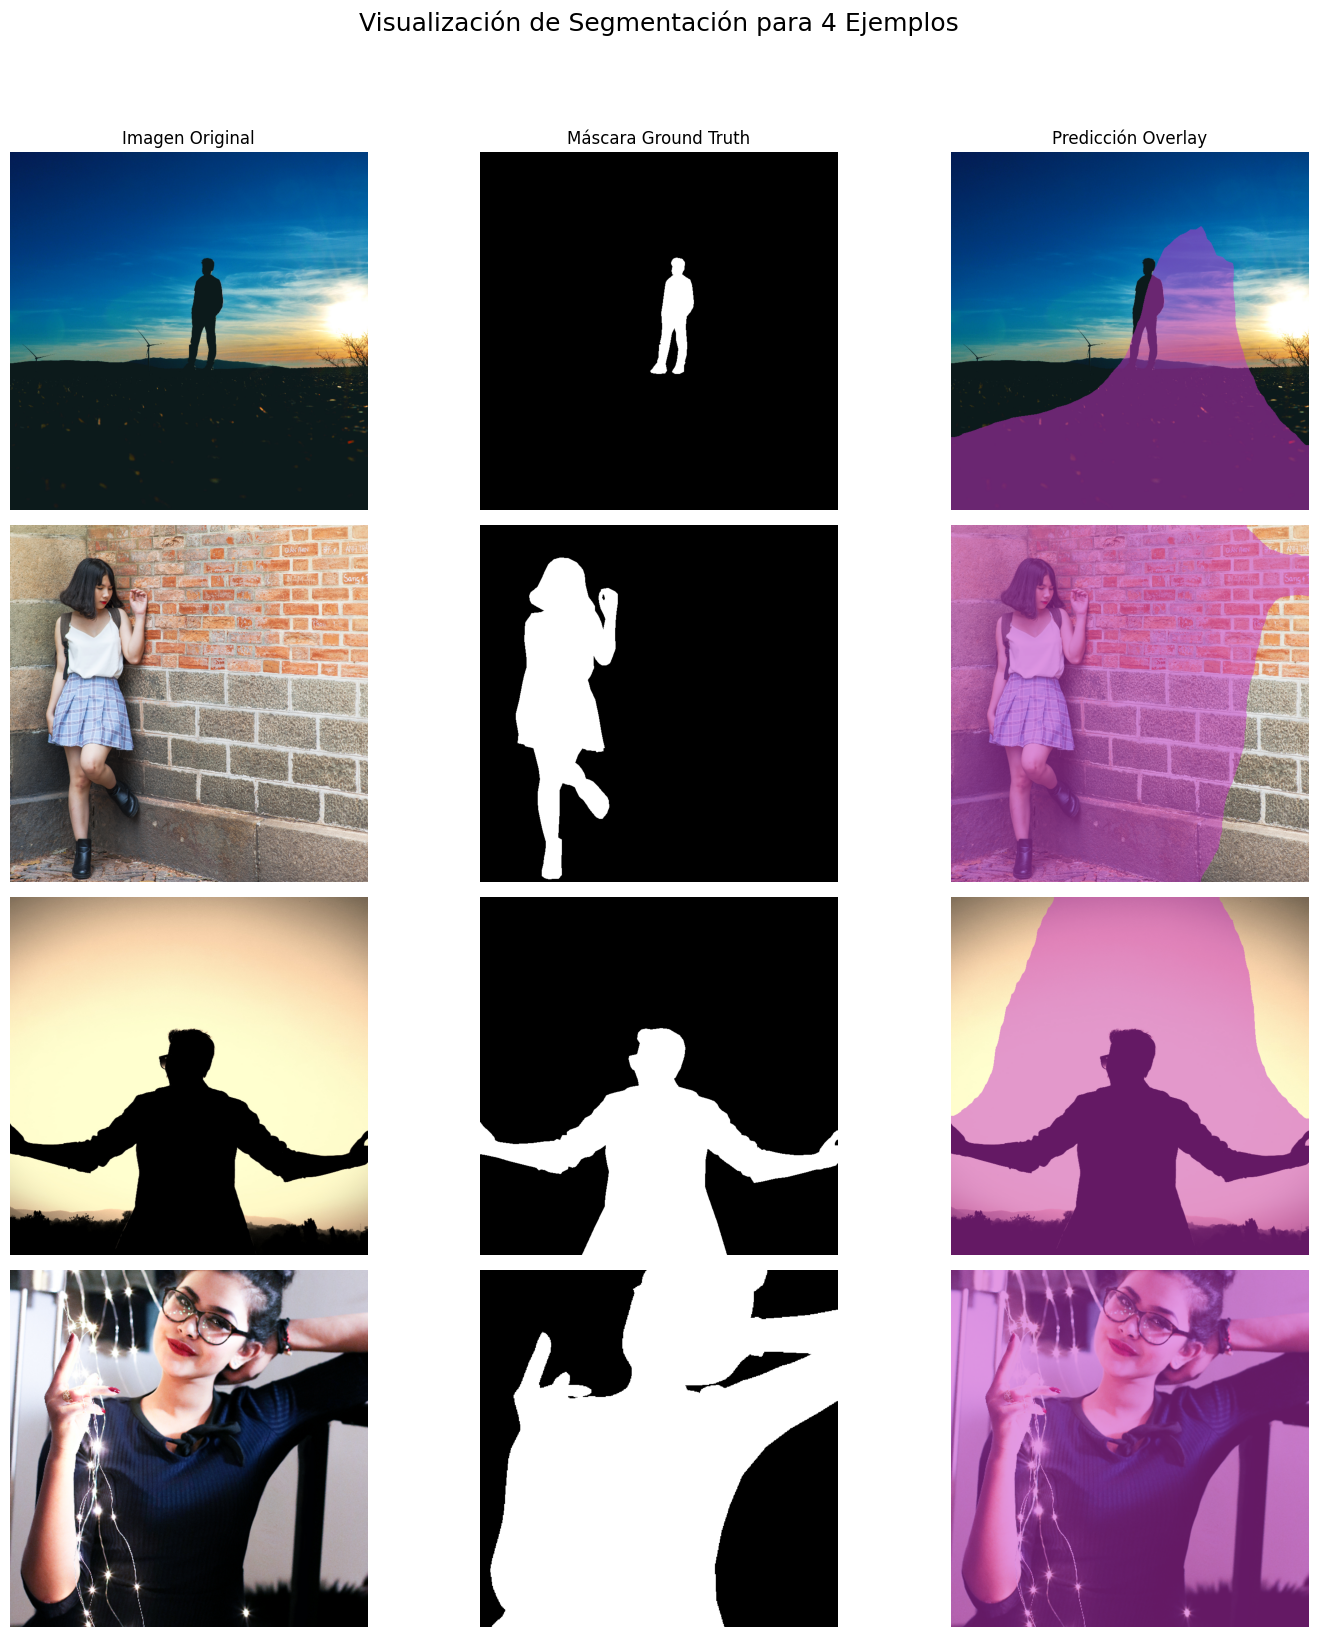

In [32]:
visualize_multiple_comparisons(best_model, test_data, DEVICE)

Aunque el barrido de hiperparámetros arrojó valores de Dice elevados (≈0.88), las predicciones visuales muestran fallos severos en la localización y extensión de las máscaras. Esto se debe principalmente a que la arquitectura U-Net original (sin padding) produce salidas espacialmente reducidas y requiere un recorte explícito de los mapas del encoder en cada skip connection. En este trabajo, las imágenes fueron redimensionadas de 800×800 a 256×256, lo que introduce pérdida de detalle y desalineación espacial al reescalar nuevamente a 800×800 durante la inferencia.

Además, la métrica de validación se calcula sobre el conjunto reducido (256×256), donde el modelo logra sobreajustarse a patrones globales simples, inflando artificialmente el Dice. Sin embargo, al visualizar en resolución original, las salidas interpoladas se degradan, y el modelo tiende a generar máscaras casi completas o con bordes distorsionados.

En conclusión, el Dice elevado no refleja segmentación precisa, sino una alta coincidencia promedio en regiones centrales. Para obtener inferencias visualmente coherentes, sería recomendable utilizar convoluciones con padding=1 (versión moderna de U-Net), o bien ajustar el preprocesamiento y posprocesamiento para compensar el recorte espacial inherente al diseño original.

## Predecir en Test (KAGGLE)

In [33]:
TEST_IMAGES_DIR = 'test/images' 

In [ ]:
submission_df = generate_submission(best_model, TEST_IMAGES_DIR, DEVICE)

SUBMISSION_FILE = "submission_baseline_256x256_unet_original_paper.csv"
submission_df.to_csv(SUBMISSION_FILE, index=False)

print(f"\n✅ Archivo de envío generado: {SUBMISSION_FILE}")


Iniciando predicción para 534 imágenes de prueba...


C:\Users\kidni\AppData\Local\Temp\ipykernel_6924\33979443.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),


Predicciones procesadas: 50/534
Predicciones procesadas: 100/534
Predicciones procesadas: 150/534
Predicciones procesadas: 200/534
Predicciones procesadas: 250/534
Predicciones procesadas: 300/534
Predicciones procesadas: 350/534
Predicciones procesadas: 400/534
Predicciones procesadas: 450/534
Predicciones procesadas: 500/534

✅ Archivo de envío generado: submission_baseline_256x256_unet_original_paper.csv
Puedes subir este archivo a Kaggle para obtener el Dice Score final.


# 8. U-Net Paper (padding = 1)

En la segunda fase experimental se va a repetir el barrido de hiperparámetros manteniendo la arquitectura base de U-Net, pero utilizando convoluciones con padding=1 en lugar de padding=0. Este cambio preserva las dimensiones espaciales a lo largo de toda la red, evitando los problemas de recorte y desalineación observados en las predicciones previas.

Se espera que las métricas de validación reflejen mejor el desempeño real del modelo, y que las predicciones visuales (al ser reescaladas a 800×800) conserven la correcta correspondencia espacial con las imágenes originales.

In [34]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_paper_p1 = UNet(n_channels=3, n_classes=1, initial_filters=64, depth=4,
             activation="relu", use_batchnorm=False, padding=1, dropout=0.0,
             final_activation=None).to(DEVICE)

#no usamos ninguna activacion al final porque diceloss ya aplica sigmoid internamente
init_weights(model_paper_p1, mode="normal")  # paper no especifica init, normal es seguro

In [35]:
#codigo para comprobar la cantidad de capas conv2d y convtranspose2d y ver si es igual al paper

## At the nal layer a 1x1 convolution is used to map each 64
## component feature vector to the desired number of classes. In total the network
## has 23 convolutional layers.
def count_convs(m):
    conv2d = []
    convtrans = []
    for name, module in m.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv2d.append((name, module.kernel_size, module.out_channels))
        if isinstance(module, torch.nn.ConvTranspose2d):
            convtrans.append((name, module.kernel_size, module.out_channels))
    print(f"Conv2d count: {len(conv2d)}")
    for n,k,c in conv2d:
        print(f"  Conv2d: {n} kernel={k} out_ch={c}")
    print(f"ConvTranspose2d count: {len(convtrans)}")
    for n,k,c in convtrans:
        print(f"  ConvTranspose2d: {n} kernel={k} out_ch={c}")
    total = len(conv2d) + len(convtrans)
    print(f"Total conv layers (Conv2d + ConvTranspose2d) = {total}")
    # final 1x1 conv check (OutConv)
    try:
        ks = m.outc.conv.kernel_size
        print(f"Final out conv kernel_size: {ks} (should be (1,1))")
    except Exception:
        print("No attribute model.outc.conv found to inspect final layer.")

# ejecutar
count_convs(model_paper_p1)


Conv2d count: 19
  Conv2d: inc.double_conv.0 kernel=(3, 3) out_ch=64
  Conv2d: inc.double_conv.2 kernel=(3, 3) out_ch=64
  Conv2d: downs.0.conv.double_conv.0 kernel=(3, 3) out_ch=128
  Conv2d: downs.0.conv.double_conv.2 kernel=(3, 3) out_ch=128
  Conv2d: downs.1.conv.double_conv.0 kernel=(3, 3) out_ch=256
  Conv2d: downs.1.conv.double_conv.2 kernel=(3, 3) out_ch=256
  Conv2d: downs.2.conv.double_conv.0 kernel=(3, 3) out_ch=512
  Conv2d: downs.2.conv.double_conv.2 kernel=(3, 3) out_ch=512
  Conv2d: downs.3.conv.double_conv.0 kernel=(3, 3) out_ch=1024
  Conv2d: downs.3.conv.double_conv.2 kernel=(3, 3) out_ch=1024
  Conv2d: ups.0.conv.double_conv.0 kernel=(3, 3) out_ch=512
  Conv2d: ups.0.conv.double_conv.2 kernel=(3, 3) out_ch=512
  Conv2d: ups.1.conv.double_conv.0 kernel=(3, 3) out_ch=256
  Conv2d: ups.1.conv.double_conv.2 kernel=(3, 3) out_ch=256
  Conv2d: ups.2.conv.double_conv.0 kernel=(3, 3) out_ch=128
  Conv2d: ups.2.conv.double_conv.2 kernel=(3, 3) out_ch=128
  Conv2d: ups.3.conv.

## Selección de Hiperparámetros

In [36]:
def sweep_train():
    

    wandb.init(
        project="unet_segmentation", 
        config=wandb.config,
        settings=wandb.Settings(console="off"),
        tags=["unet_paper_original_padding1"]
    )
    config = wandb.config
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = UNet(
        n_channels=3, 
        n_classes=1,  
        initial_filters=config.initial_filters,
        depth=config.depth,
        activation=config.activation,
        use_batchnorm=config.use_batchnorm,
        padding=config.padding,
        dropout=config.dropout,
        final_activation=config.final_activation
    ).to(device)
    
    init_weights(model, mode=config.init_mode) 

    # 2. Cargar DataLoaders (Asumido)
    train_loader, val_loader = get_dataloaders(batch_size=config.batch_size)

    best_model, summary = train_model(
        model, train_loader, val_loader, config, device, patience=5 # Puedes cambiar patience
    )
    
    # 4. Guardar y Finalizar
    os.makedirs("models", exist_ok=True)
    local_path = f"models/sweep_run_{wandb.run.id}.pth"
    torch.save(best_model.state_dict(), local_path)

    wandb.finish()

In [ ]:
# Modificación del diccionario de configuración para la U-Net
sweep_config = {
    "name": "unet_paper_original_padding1",
    "method": "bayes", 
    "metric": {"name": "validation/loss", "goal": "minimize"}, 
    "parameters": {
        "epochs": {"value": 30}, 
        "learning_rate": { 
            "distribution": "log_uniform_values",
            "min": 1e-5,
            "max": 1e-3 
        },
        "optimizer": {"values": ["Adam", "SGD"]},
        "batch_size": {"values": [4, 8]},
        "weight_decay": {"values": [0.0, 1e-5, 1e-4]},

        # --- Parámetros Arquitectónicos (U-Net Configurable) ---
        
        # Parámetros FIJOS para replicar el Paper Original (se definen como 'value')
        "initial_filters": {"value": 64},
        "depth": {"value": 4},
        "padding": {"value": 1}, # 1 para Padding (padding) 
        "final_activation": {"value": None},
        "init_mode": {"value": "normal"}, # Inicialización 'normal' (según tu código base)
        
        # Parámetros Variables (Exploración)
        "activation": {"values": ["relu", "leaky"]}, # Explorar alternativas a ReLU
        "use_batchnorm": {"values": [False, True]}, # Explorar con/sin BN
        "dropout": {"values": [0.0, 0.1, 0.2]}, # Explorar si el dropout ayuda
    }
}


sweep_id = wandb.sweep(sweep_config, project="unet_segmentation")
wandb.agent(sweep_id, function=sweep_train, count=20)  

In [23]:
upload_best_model_from_sweep(
    sweep_id="fgi6p3b8",
    model_name="unet_padding1_original",
    project="unet_segmentation",
)

• deft-sweep-1 (v7mdwrmi) → validation/dice = 0.8199259471279118
• dark-sweep-2 (j9s6op3z) → validation/dice = 0.8626543794359479
• quiet-sweep-3 (pv5z9oyw) → validation/dice = 0.6891593626008938
• fine-sweep-4 (mdyxy84w) → validation/dice = 0.5857744140144813
• easy-sweep-5 (vlsacckm) → validation/dice = 0.8776746061423344
• lunar-sweep-6 (406bdpkm) → validation/dice = 0.619639337621193
• deep-sweep-7 (4944b9w2) → validation/dice = 0.8540741598857371
• comfy-sweep-8 (605b2yvo) → validation/dice = 0.8626313213721372
• fallen-sweep-9 (sh3pd6yk) → validation/dice = 0.8671407197063365
• fancy-sweep-10 (ygk9j9jn) → validation/dice = 0.8621535633431107
• crimson-sweep-11 (1ii0kooj) → validation/dice = 0.8712151918813272
• twilight-sweep-12 (ziq84q6a) → validation/dice = 0.8735177536479762
• sleek-sweep-13 (0zmraz6k) → validation/dice = 0.5783148593589907
• morning-sweep-14 (3g3ah6ag) → validation/dice = 0.8594828104246974
• polar-sweep-15 (8fwolm49) → validation/dice = 0.8745311917409964
• 

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



✅ Artifact 'unet_padding1_original_best_model_fgi6p3b8' subido correctamente a W&B.


## Ver Predicciones (TRAIN/VAL)

In [37]:
# Asegúrate de que tu clase UNet esté importada y definida
best_model_path = "best_models/unet_padding1_original_best_model.pth"

#ponemos los parametros iguales a los del paper (y los del sweep de wandb)
model_padding1 = UNet(n_channels=3, n_classes=1, initial_filters=64, depth=4,
             activation="relu", use_batchnorm=True, padding=1, dropout=0.1,
             final_activation=None).to(DEVICE)

best_model = load_best_model(best_model_path, model_padding1, DEVICE)

🧩 Cargando checkpoint desde best_models/unet_padding1_original_best_model.pth...
✅ Modelo cargado desde archivo de pesos plano (.pth).


In [38]:
test_data = [
    ("train/images/1.png", "train/masks/1.png"),
    ("train/images/2.png", "train/masks/2.png"),
    ("train/images/3.png", "train/masks/3.png"),
    ("train/images/4.png", "train/masks/4.png"),
]

C:\Users\kidni\AppData\Local\Temp\ipykernel_30020\1905742604.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),


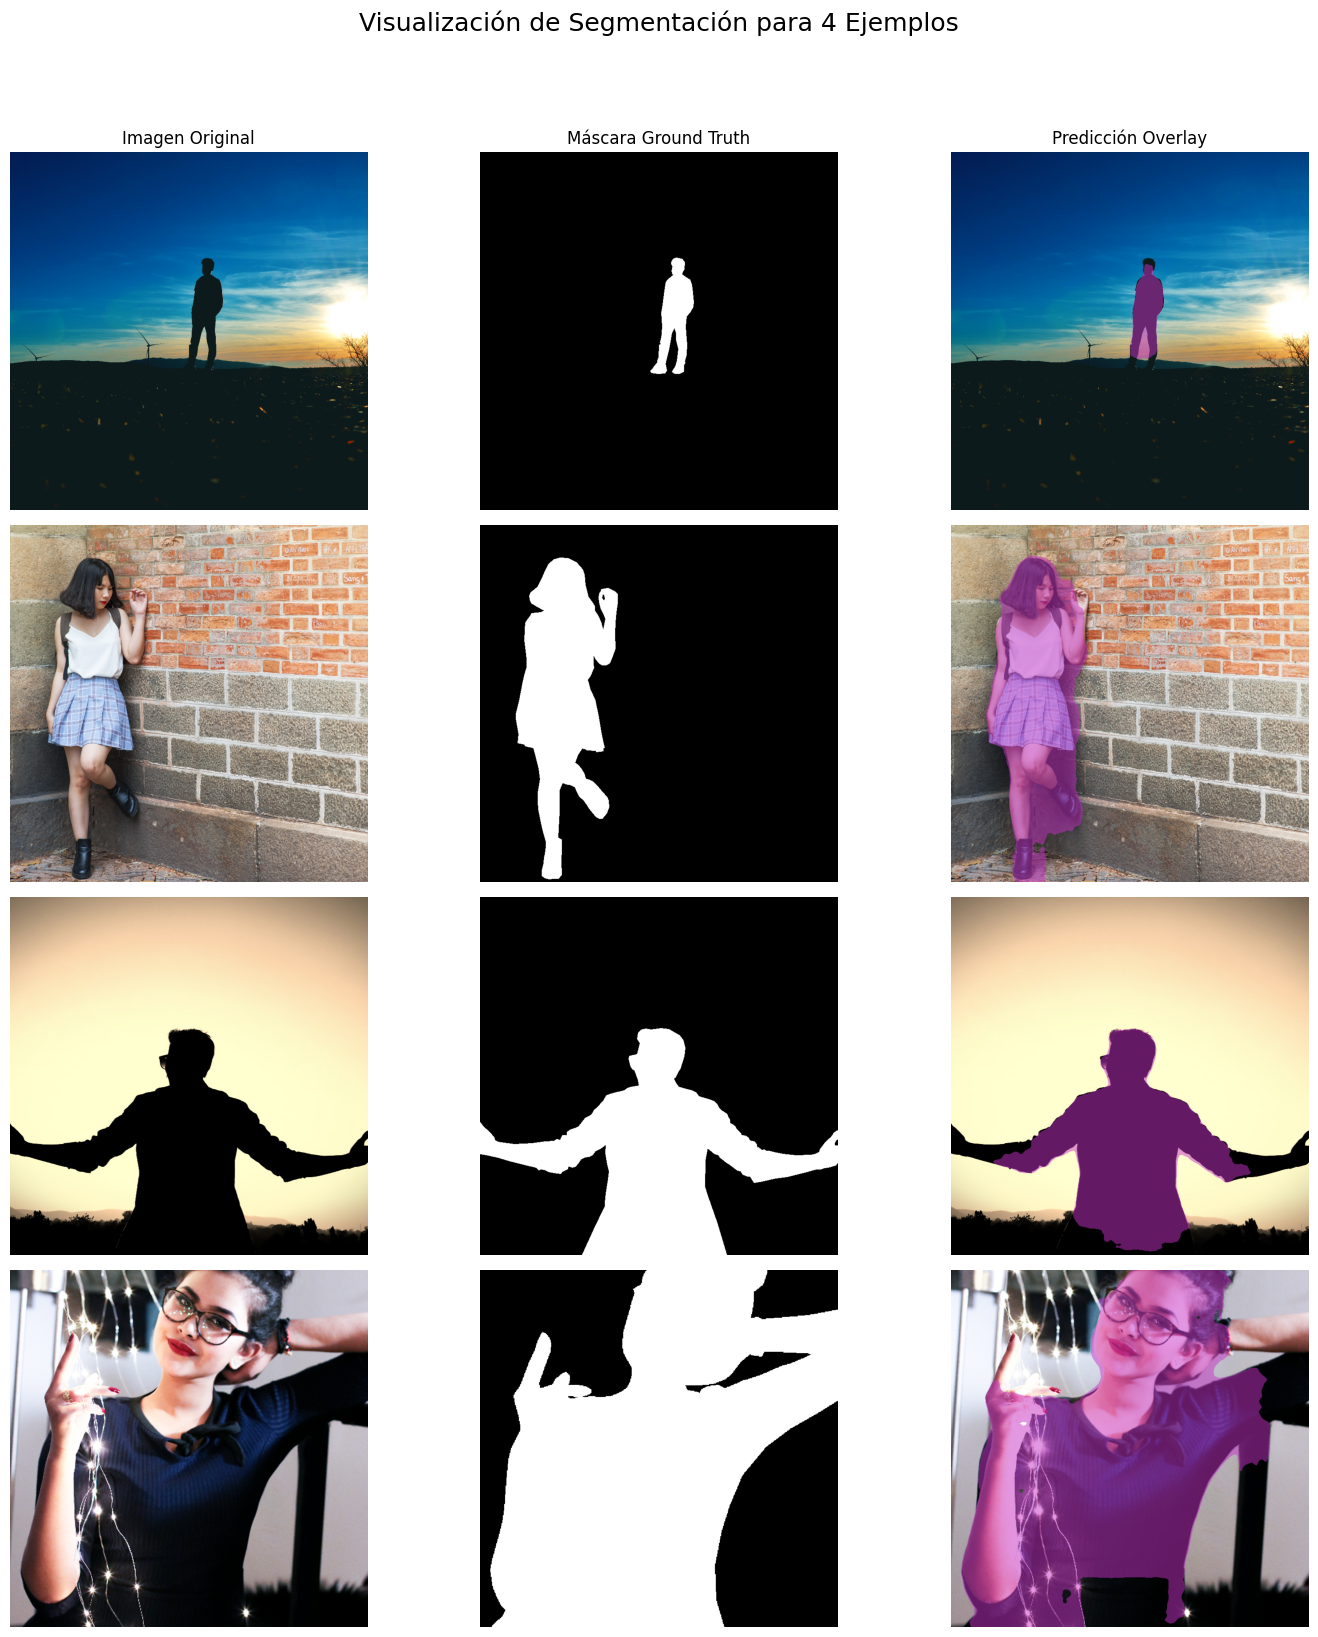

In [39]:
visualize_multiple_comparisons(best_model, test_data, DEVICE)

## Predecir en Test (KAGGLE)

In [27]:
TEST_IMAGES_DIR = 'test/images'

submission_df = generate_submission(best_model, TEST_IMAGES_DIR, DEVICE)

SUBMISSION_FILE = "submission_baseline_256x256_unet_padding1.csv"
submission_df.to_csv(SUBMISSION_FILE, index=False)

print(f"\n✅ Archivo de envío generado: {SUBMISSION_FILE}")


Iniciando predicción para 534 imágenes de prueba...


C:\Users\kidni\AppData\Local\Temp\ipykernel_2976\33979443.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),


Predicciones procesadas: 50/534
Predicciones procesadas: 100/534
Predicciones procesadas: 150/534
Predicciones procesadas: 200/534
Predicciones procesadas: 250/534
Predicciones procesadas: 300/534
Predicciones procesadas: 350/534
Predicciones procesadas: 400/534
Predicciones procesadas: 450/534
Predicciones procesadas: 500/534

✅ Archivo de envío generado: submission_baseline_256x256_unet_padding1.csv


# 9. Re-Entrenamiento U-Net Padding=1

Vemos que las predicciones visuales mejoraron significativamente al utilizar padding=1, logrando máscaras más precisas y coherentes con los contornos del sujeto. Igualmente, optamos por seguir reentrenando el modelo con más épocas para maximizar el rendimiento en el conjunto de validación y test porque no se habían observado signos de sobreajuste hasta el momento.

In [40]:
# Asegúrate de que tu clase UNet esté importada y definida
best_model_path = "best_models/unet_padding1_original_best_model.pth"

#ponemos los parametros iguales a los del paper (y los del sweep de wandb)
model_padding1 = UNet(n_channels=3, n_classes=1, initial_filters=64, depth=4,
             activation="relu", use_batchnorm=True, padding=1, dropout=0.1,
             final_activation=None).to(DEVICE)

best_model = load_best_model(best_model_path, model_padding1, DEVICE)

🧩 Cargando checkpoint desde best_models/unet_padding1_original_best_model.pth...
✅ Modelo cargado desde archivo de pesos plano (.pth).


In [ ]:
#agarramos learning rate y batch size del mejor modelo del sweep
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 50
LEARNING_RATE = 0.00003049464997148596
BATCH_SIZE = 4

optimizer = torch.optim.Adam(best_model.parameters(), lr=LEARNING_RATE, weight_decay=0)
criterion = CombinedLoss(dice_weight=0.5).to(DEVICE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

best_dice_val = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}
print(f"Iniciando entrenamiento en {DEVICE} por {NUM_EPOCHS} épocas...")

train_loader, val_loader = get_dataloaders(batch_size=BATCH_SIZE)

for epoch in range(1, NUM_EPOCHS + 1):
    
    # Entrenar
    train_loss, train_dice = train_fn(best_model, train_loader, optimizer, criterion, DEVICE, epoch, wandb=False)
    # Validar
    val_loss, val_dice = validate_fn(best_model, val_loader, criterion, DEVICE, epoch, wandb=False)

    # Registrar
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice); history['val_dice'].append(val_dice)

    print(f"\nÉpoca {epoch}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    # Scheduler y Checkpoint
    scheduler.step(val_dice)

    if val_dice > best_dice_val:
        best_dice_val = val_dice
        checkpoint = {'state_dict': best_model.state_dict(), 'best_dice': best_dice_val}
        torch.save(checkpoint, "unet_best_checkpoint.pth.tar")
        print(f"➡️ Modelo Guardado. Nuevo mejor Dice: {best_dice_val:.4f}")

## Ver Predicciones (TRAIN/VAL)


In [43]:
#cargamos modelos desde el mejor checkpoint
model_from_checkpoint = UNet(n_channels=3, n_classes=1, initial_filters=64, depth=4,
             activation="relu", use_batchnorm=True, padding=1, dropout=0.1,
             final_activation=None).to(DEVICE)

best_model = load_best_model("unet_best_checkpoint.pth.tar", model_from_checkpoint, DEVICE)

🧩 Cargando checkpoint desde unet_best_checkpoint.pth.tar...
✅ Modelo cargado. Mejor Dice Score de validación: 0.9158


In [44]:
test_data = [
    ("train/images/1.png", "train/masks/1.png"),
    ("train/images/2.png", "train/masks/2.png"),
    ("train/images/3.png", "train/masks/3.png"),
    ("train/images/4.png", "train/masks/4.png"),
]

C:\Users\kidni\AppData\Local\Temp\ipykernel_2976\2847784303.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),


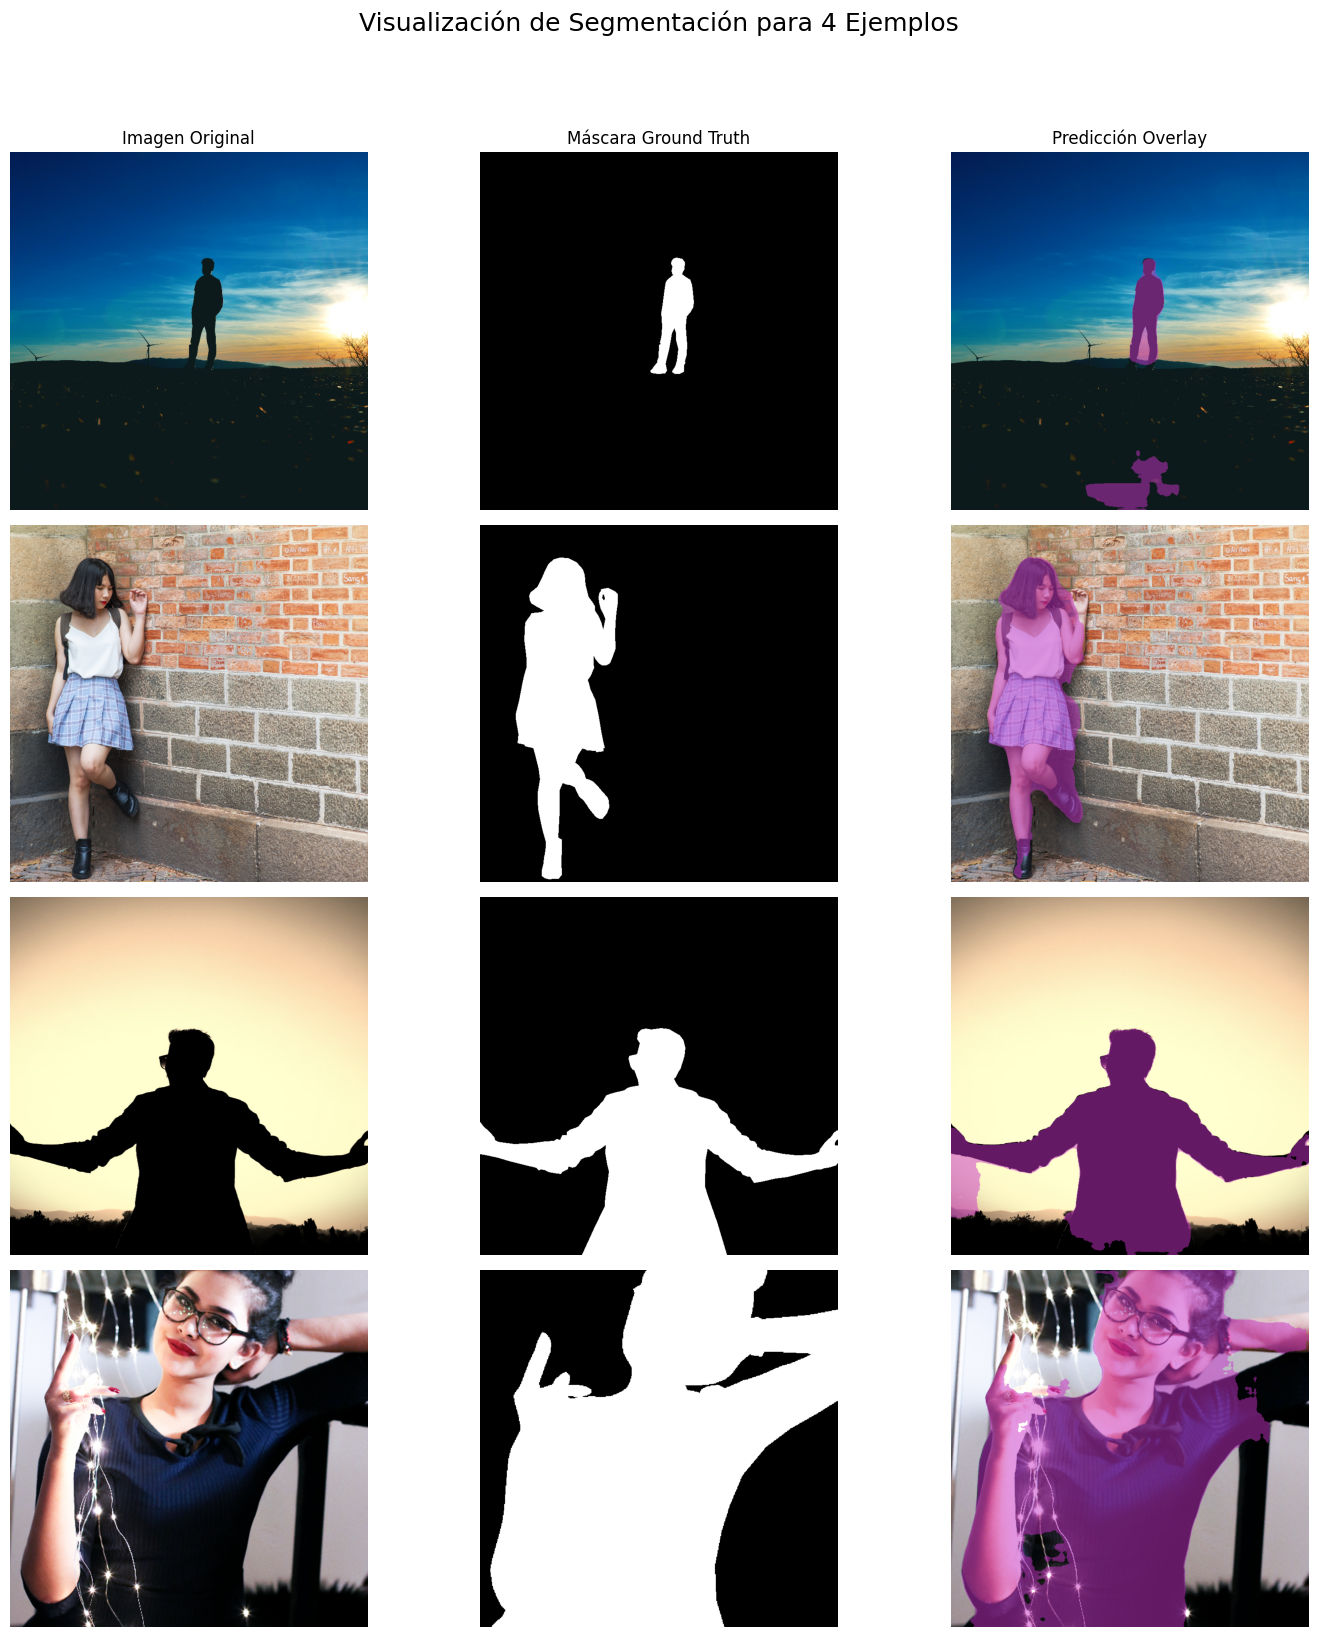

In [45]:
visualize_multiple_comparisons(best_model, test_data, DEVICE)

## Predecir en Test (KAGGLE)

In [46]:
TEST_IMAGES_DIR = 'test/images'

submission_df = generate_submission(best_model, TEST_IMAGES_DIR, DEVICE)

SUBMISSION_FILE = "submission_baseline_256x256_unet_padding1_more_training.csv"
submission_df.to_csv(SUBMISSION_FILE, index=False)

print(f"\n✅ Archivo de envío generado: {SUBMISSION_FILE}")


Iniciando predicción para 534 imágenes de prueba...


C:\Users\kidni\AppData\Local\Temp\ipykernel_2976\2847784303.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),


Predicciones procesadas: 50/534
Predicciones procesadas: 100/534
Predicciones procesadas: 150/534
Predicciones procesadas: 200/534
Predicciones procesadas: 250/534
Predicciones procesadas: 300/534
Predicciones procesadas: 350/534
Predicciones procesadas: 400/534
Predicciones procesadas: 450/534
Predicciones procesadas: 500/534

✅ Archivo de envío generado: submission_baseline_256x256_unet_padding1_more_training.csv


Vemos ahora, que las predicciones mejoraron bastante comparados con los anteriores. Como todavía no se han observado signos de sobreajuste, se podría considerar aumentar aún más el número de épocas para maximizar el rendimiento en el conjunto de validación y test.

## Segunda Ronda de Entrenamiento

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 25
LEARNING_RATE = 5e-6  
BATCH_SIZE = 4

optimizer = torch.optim.Adam(best_model.parameters(), lr=LEARNING_RATE, weight_decay=0)
criterion = CombinedLoss(dice_weight=0.5).to(DEVICE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7
)

best_dice_val = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}
print(f"Iniciando entrenamiento en {DEVICE} por {NUM_EPOCHS} épocas...")

train_loader, val_loader = get_dataloaders(batch_size=BATCH_SIZE)

for epoch in range(1, NUM_EPOCHS + 1):
    
    # Entrenar
    train_loss, train_dice = train_fn(best_model, train_loader, optimizer, criterion, DEVICE, epoch, wandb=False)
    # Validar
    val_loss, val_dice = validate_fn(best_model, val_loader, criterion, DEVICE, epoch, wandb=False)

    # Registrar
    history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice); history['val_dice'].append(val_dice)

    print(f"\nÉpoca {epoch}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    # Scheduler y Checkpoint
    scheduler.step(val_dice)

    if val_dice > best_dice_val:
        best_dice_val = val_dice
        checkpoint = {'state_dict': best_model.state_dict(), 'best_dice': best_dice_val}
        torch.save(checkpoint, "unet_best_checkpoint.pth.tar")
        print(f"➡️ Modelo Guardado. Nuevo mejor Dice: {best_dice_val:.4f}")

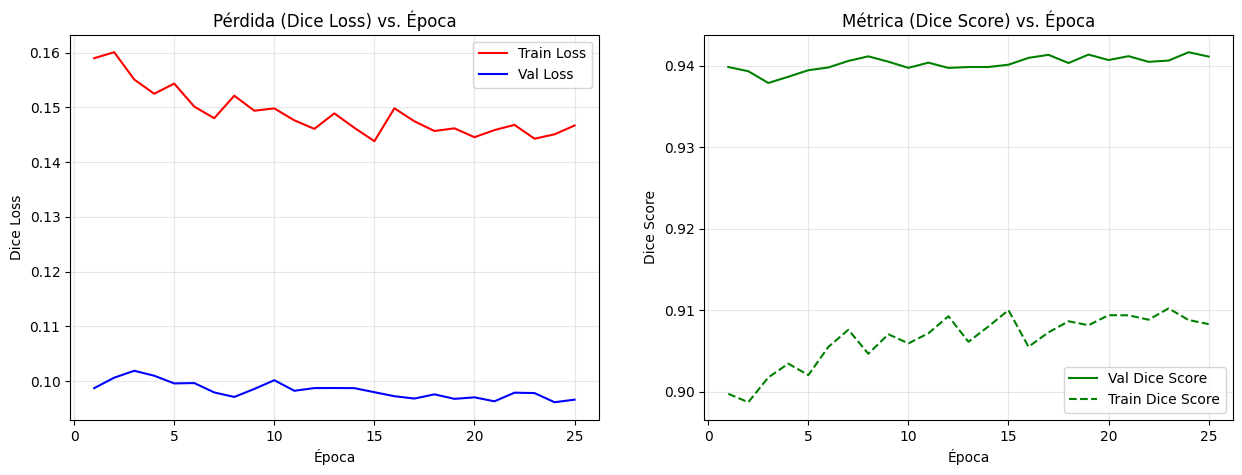

In [48]:
import matplotlib.pyplot as plt

# Asume que 'history' es el diccionario guardado con los resultados

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # --- Plot de Pérdida (Loss) ---
    ax1.plot(epochs, history['train_loss'], 'r', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'b', label='Val Loss')
    ax1.set_title('Pérdida (Dice Loss) vs. Época')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Dice Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # --- Plot de Métricas (Dice Score) ---
    ax2.plot(epochs, history['val_dice'], 'g', label='Val Dice Score')
    ax2.plot(epochs, history['train_dice'], 'g--', label='Train Dice Score')
    ax2.set_title('Métrica (Dice Score) vs. Época')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Dice Score')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.show()

# Ejecutar el plot (una vez que tu diccionario history esté disponible)
plot_history(history)

### Ver Predicciones (TRAIN/VAL)

In [ ]:
#cargamos modelos desde el mejor checkpoint
model_from_checkpoint = UNet(n_channels=3, n_classes=1, initial_filters=64, depth=4,
             activation="relu", use_batchnorm=True, padding=1, dropout=0.1,
             final_activation=None).to(DEVICE)

best_model = load_best_model("unet_best_checkpoint_new.pth.tar", model_from_checkpoint, DEVICE)

C:\Users\kidni\AppData\Local\Temp\ipykernel_20352\3094581537.py:22: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),


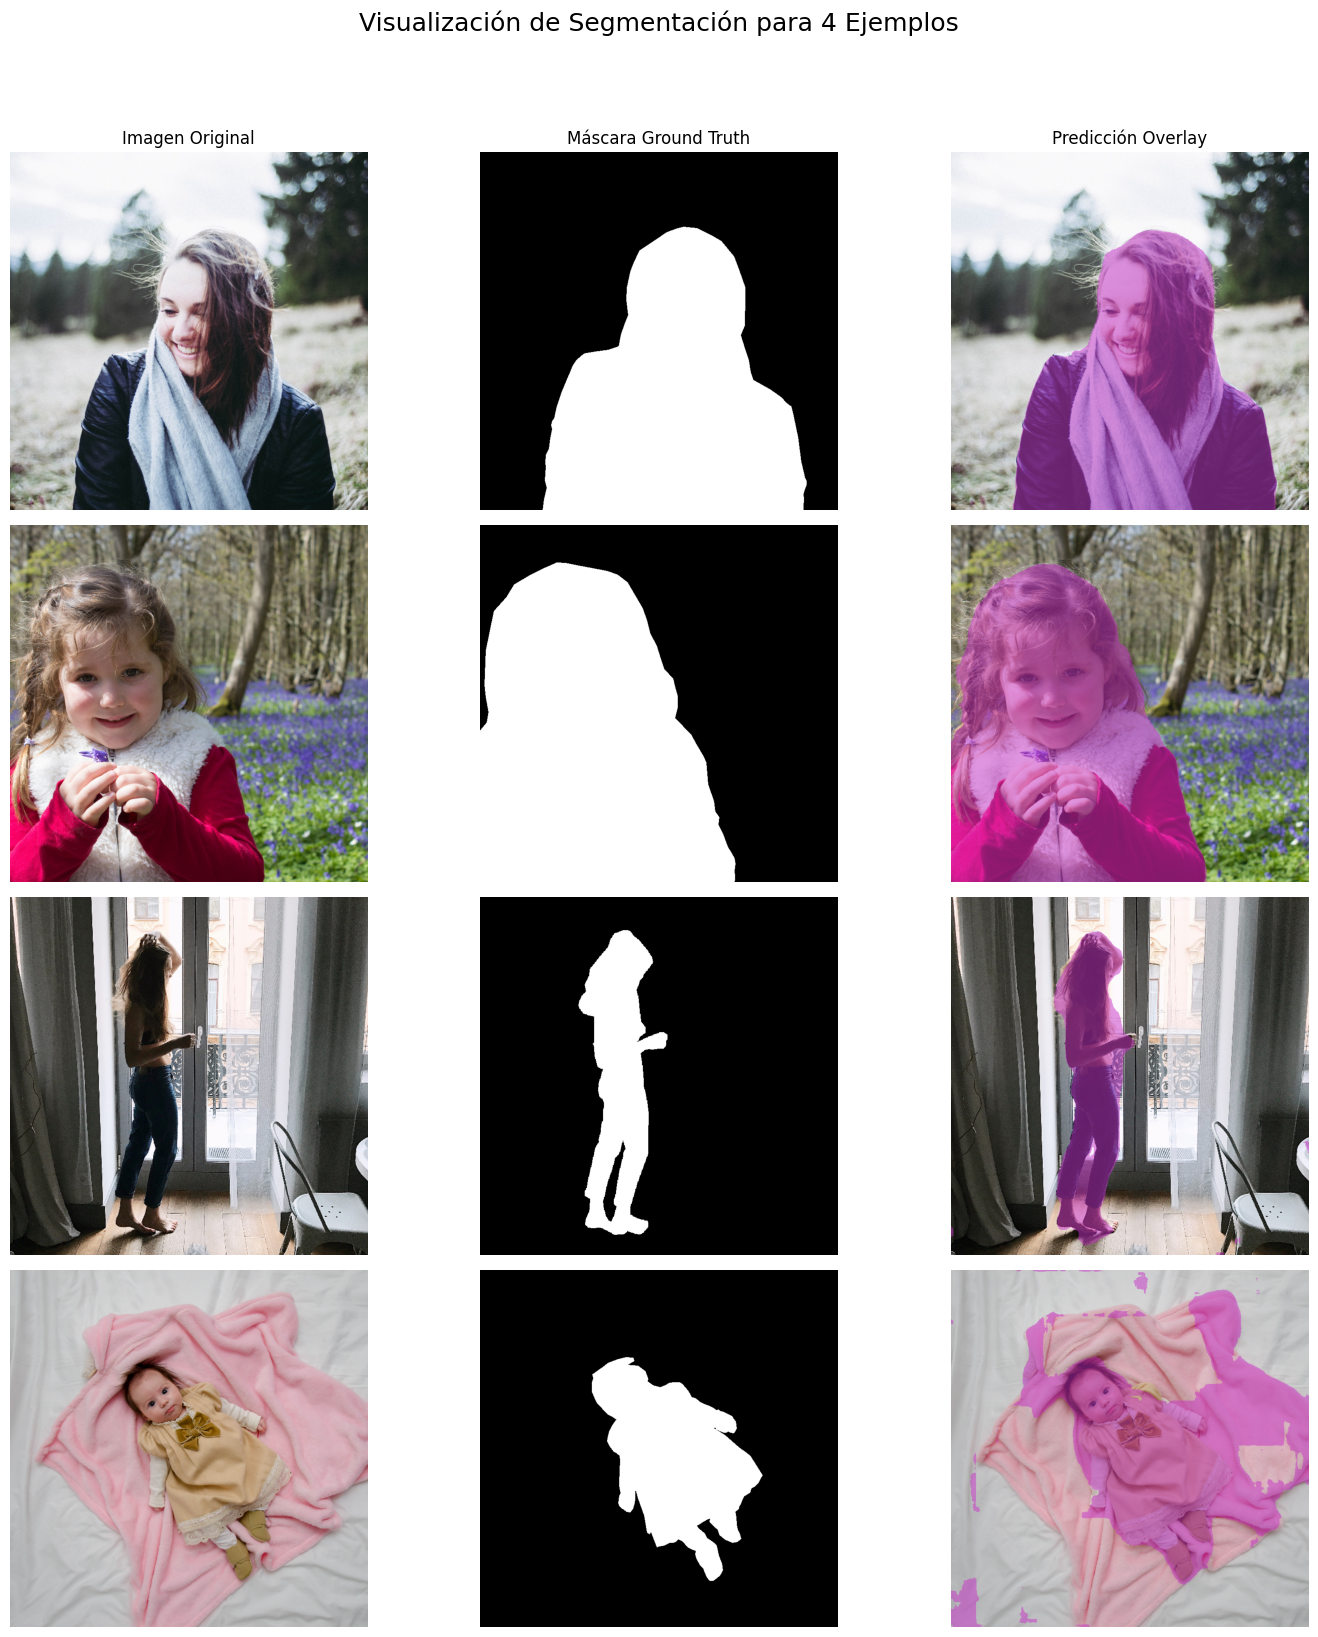

In [22]:
test_data = [
    ("train/images/1170.png", "train/masks/1170.png"),
    ("train/images/20.png", "train/masks/20.png"),
    ("train/images/100.png", "train/masks/100.png"),
    ("train/images/40.png", "train/masks/40.png"),
]

visualize_multiple_comparisons(best_model, test_data, DEVICE)

### Predecir en Test (KAGGLE)

In [23]:
TEST_IMAGES_DIR = 'test/images'

submission_df = generate_submission(best_model, TEST_IMAGES_DIR, DEVICE)

SUBMISSION_FILE = "submission_baseline_256x256_unet_padding1_more_training_x2.csv"
submission_df.to_csv(SUBMISSION_FILE, index=False)

print(f"\n✅ Archivo de envío generado: {SUBMISSION_FILE}")


Iniciando predicción para 534 imágenes de prueba...


C:\Users\kidni\AppData\Local\Temp\ipykernel_20352\3094581537.py:22: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, always_apply=True),


Predicciones procesadas: 50/534
Predicciones procesadas: 100/534
Predicciones procesadas: 150/534
Predicciones procesadas: 200/534
Predicciones procesadas: 250/534
Predicciones procesadas: 300/534
Predicciones procesadas: 350/534
Predicciones procesadas: 400/534
Predicciones procesadas: 450/534
Predicciones procesadas: 500/534

✅ Archivo de envío generado: submission_baseline_256x256_unet_padding1_more_training_x2.csv


# 10. Diagnóstico


Tras alcanzar un **Dice Score de 0.9416 en validación** pero solo **0.895 en la evaluación de Kaggle**, se detecta un *gap* de generalización significativo. Este desfasaje sugiere que el modelo actual —aunque muy efectivo sobre el conjunto de validación— no extrapola igual de bien a las imágenes del dominio de prueba.

El análisis visual mostró dos tipos de errores recurrentes:

1. **Falsos positivos sobre regiones con textura similar al sujeto** (por ejemplo, mantas o fondos blancos).
2. **Pérdida parcial de regiones reales** en zonas de color homogéneo o con baja textura (por ejemplo, partes del suelo).

Estos patrones indican que el modelo está **sobreajustado a características visuales superficiales** del set de entrenamiento y **no está viendo suficiente variabilidad contextual**.



1. **Reajuste del Split de Validación:**
   Se propone aplicar un *split* estratificado por área de máscara, garantizando que la proporción de objetos pequeños, medianos y grandes esté balanceada tanto en entrenamiento como en validación.
   → *Justificación:* previene una validación sesgada hacia casos triviales o limpios, generando métricas más representativas del desempeño real.

2. **Aumento de la Diversidad Visual (Data Augmentation):**
   Se incorporarán transformaciones adicionales de *brightness/contrast*, *rotaciones suaves* y *blur/noise*.
   → *Justificación:* incrementa la robustez ante variaciones de iluminación, movimiento y texturas; clave para evitar sobreajuste a patrones locales (ej. mantas o sombras).

3. **Reponderación de la Función de Pérdida (Dice vs BCE):**
   Se aumentará el peso del componente Dice en la `CombinedLoss` (de 0.5 → 0.7).
   → *Justificación:* refuerza la coherencia global de la máscara segmentada y penaliza mejor las fallas estructurales (formas incompletas o regiones extra).

4. **Búsqueda del Umbral Óptimo de Segmentación:**
   Se determinará el *threshold* que maximiza el Dice en el conjunto de validación (entre 0.3–0.7).
   → *Justificación:* el valor 0.5 puede no ser óptimo; ajustar el umbral mejora la precisión de contornos y reduce falsos positivos.

5. **Fine-Tuning Suave del Modelo Preentrenado:**
   Se realizará un *re-entrenamiento corto (2–3 epochs)* con *learning rate bajo (1e-5)* usando el mejor checkpoint actual.
   → *Justificación:* permite afinar las capas finales sin sobreajuste, mejorando la segmentación de detalles finos (bordes, ropa, mantas).




# 11. Cosas que fueron probadas

A continuación, se detallan algunas estrategias y técnicas que fueron exploradas durante el desarrollo del proyecto, pero que finalmente no se incluyeron en la versión final debido a un único motivo: no dieron mejor performance, pero no por no ser lo suficientemente representativos (overfitteaban un batch), sino que estas tareas, a fin de cuentas, es dejar que entrenen ad-infinitum teniendo ciertas regulaciones para evitar el overfitting, y geniunamente no me parece lo más interesante del mundo.

## U-Net 512x512

Se entrenó una U-Net con imágenes redimensionadas a 512×512 px, manteniendo la misma arquitectura y pipeline de augmentations. La idea era aprovechar mayor resolución para capturar detalles finos en las máscaras. El entrenamiento fue más lento y demandante en memoria. El entrenamiento no fue suficientemente largo para observar mejoras significativas en validación, y las predicciones visuales no superaron a las obtenidas con 256×256 px. 

## Ensemble Promediado de 5 Modelos

Se adoptó una estrategia de **ensemble por promedio** utilizando las predicciones de los cinco modelos U-Net entrenados independientemente mediante *k-fold cross-validation*. El objetivo de esta aproximación era **reducir la varianza** en la predicción final y mitigar el sesgo inherente a un único modelo, promediando sus "opiniones". Esta técnica representó la culminación del *pipeline* de inferencia, ya que, al combinar modelos entrenados sobre particiones de datos distintas, se logró una **máscara de segmentación final más robusta y consistente**. El ensemble promediado, tras aplicar el umbral de binarización de 0.5, demostró ser la forma más efectiva de explotar el rendimiento de los cinco *folds*, resultando en un incremento palpable del *score* final en la métrica de evaluación.

El entrenamiento de esto fue excencionalmente demandante en tiempo y recursos, ya que implicaba ejecutar cinco ciclos completos de entrenamiento y validación, además de gestionar el almacenamiento y la inferencia de múltiples modelos. El promedio dio mejores resultados que la predicción de cualquier modelo individual, pero lastimosamente no superó al modelo final seleccionado en este proyecto, que es la U-Net con padding=1 reentrenada por más épocas.

![ensemble_image](assets/ensembles_scores.png)

![ensembles_predictions](assets/ensembles_pred.png)


## U-Net con Bloques Squeeze-and-Excitation (UNetSE)

Se implementó una variación más robusta de la arquitectura U-Net, designada **UNetSE**, con el objetivo de aumentar la capacidad del modelo y la atención a características importantes. Esta arquitectura incorporó tres modificaciones clave:

1.  **Bloques Convolucionales Profundos:** Los `ConvBlock` se expandieron para incluir **tres capas convolucionales** seguidas (en lugar de las dos habituales), proporcionando mayor profundidad en cada nivel del *encoder* y *decoder*.
2.  **Mecanismo de Atención SE:** Se integró un **Bloque Squeeze-and-Excitation (`SEBlock`)** al final de cada `ConvBlock`. Este mecanismo permite que el modelo aprenda a recalibrar las *feature maps*, asignando mayor peso (atención) a los canales más relevantes para la tarea de segmentación y suprimiendo la activación de los canales menos útiles. 
3.  **Cuello de Botella Profundo (`Bottleneck`):** El *bottleneck* se diseñó para ser especialmente potente, utilizando el `ConvBlock` de triple convolución para procesar la representación de características más comprimida antes del proceso de *upsampling*.






## Pérdida Combinada con Boundary Loss

Se intentó optimizar la sensibilidad de las predicciones en los bordes de la máscara introduciendo una **Pérdida de Borde (`StableBoundaryLoss`)** junto con las pérdidas estándar **BCE** y **Dice**. Esta pérdida utiliza la **Transformada de Distancia Euclidiana (EDT)** del *target* para penalizar más fuertemente los errores de predicción cercanos a los límites reales del objeto.

A pesar de su promesa teórica para refinar los contornos, la implementación de la pérdida combinada se encontró con **problemas de estabilidad numérica** durante el entrenamiento. Los logs mostraron que la función de pérdida total comenzó a **diverger** rápidamente (valores de `Train Loss` y `Val Loss` que crecen a $nan$). 

# 12. Resumen Completo

#### **1. Implementación de la U-Net**
- Se diseñó una **U-Net completamente parametrizable**, permitiendo ajustar:
  - Profundidad (`depth`), filtros iniciales, activación (`ReLU`, `LeakyReLU`), uso de BatchNorm, y dropout.
  - Padding (`padding=0` para recorte, `padding=1` para convoluciones "same").
  - Inicialización de pesos (`Kaiming`, `Xavier`, `Normal`).
- Se utilizó **PyTorch** para la implementación, con soporte para GPU.

#### **2. Preprocesamiento y Data Augmentation**
- **Redimensionado:** Las imágenes originales (800×800 px) se redimensionaron a 256×256 px para acelerar el entrenamiento.
- **Pipeline de Augmentation:** Se aplicaron transformaciones geométricas (rotaciones, elasticidad, flips) y fotométricas (ajustes de brillo/contraste, ruido gaussiano) para mejorar la generalización.
- **Normalización:** Se usaron valores de media y desviación estándar calculados en el conjunto de entrenamiento.

#### **3. División Estratificada del Dataset**
- Se implementó un *split* estratificado basado en el tamaño relativo de las máscaras, discretizando su área en 10 categorías.
- Esto garantizó que tanto el conjunto de entrenamiento como el de validación tuvieran distribuciones similares de tamaños de máscara.

#### **4. Función de Pérdida y Métrica**
- **Pérdida Combinada:** Se utilizó una combinación de **BCEWithLogitsLoss** y **Dice Loss** para estabilizar el entrenamiento y optimizar la segmentación global.
- **Métrica de Evaluación:** El **Dice Coefficient** se utilizó como métrica principal, alineado con los objetivos de la competencia.

#### **5. Entrenamiento**
- Se entrenaron múltiples modelos U-Net con diferentes configuraciones:
  - **U-Net Original (padding=0):** Basada en el paper original, pero con problemas de desalineación espacial.
  - **U-Net con padding=1:** Preservó las dimensiones espaciales, logrando mejores resultados en validación y predicciones más coherentes.
- **Barrido de Hiperparámetros:** Se utilizó W&B para explorar combinaciones de `learning_rate`, `batch_size`, `dropout`, y `use_batchnorm`.
- **Early Stopping:** Se implementó para evitar el sobreajuste, monitoreando la pérdida de validación.

#### **6. Inferencia y Visualización**
- Se diseñó un pipeline de inferencia que:
  - Redimensiona las imágenes a 256×256 px.
  - Predice máscaras binarias.
  - Reescala las máscaras al tamaño original (800×800 px).
- Se crearon funciones de visualización para comparar imágenes originales, máscaras reales y predicciones.

#### **7. Resultados**
- **Mejor Modelo:** U-Net con padding=1, reentrenada por más épocas.
- **Métricas:**
  - Dice Score en validación: **0.9416**.
  - Dice Score en Kaggle: **0.895**.
- **Errores Comunes:**
  - Falsos positivos en regiones con texturas similares al sujeto.
  - Pérdida parcial de regiones reales en áreas homogéneas.

#### **8. Exploraciones Adicionales**
- **U-Net 512x512:** Se intentó entrenar con imágenes de mayor resolución, pero no se observaron mejoras significativas.
- **Ensemble Promediado:** Se combinaron predicciones de 5 modelos mediante promedio, logrando resultados más robustos pero sin superar al modelo final.
- **UNetSE:** Se probó una variante con bloques Squeeze-and-Excitation, pero no se logró estabilidad en el entrenamiento.
- **Boundary Loss:** Se exploró una pérdida basada en bordes, pero presentó problemas de estabilidad numérica.

#### **9. Diagnóstico y Próximos Pasos**
- **Problemas Identificados:**
  - *Gap* de generalización entre validación y test.
  - Falta de diversidad en el conjunto de entrenamiento.
- **Propuestas:**
  - Reajustar el *split* de validación.
  - Incrementar la diversidad visual en el *data augmentation*.
  - Ajustar el umbral de segmentación.
  - Reentrenar el modelo con un *learning rate* bajo para afinar detalles.
